In [1]:
import cv2
import numpy as np

def count_red_pixels(image):
    # Convert the image to BGR color space
    image_bgr = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Define the lower and upper bounds for red color in BGR format
    lower_red = np.array([0, 0, 100])
    upper_red = np.array([50, 50, 255])

    # Threshold the image to get a binary mask of red pixels
    mask = cv2.inRange(image_bgr, lower_red, upper_red)

    # Count the number of white pixels in the mask
    count = cv2.countNonZero(mask)

    return count


In [2]:
def print_pixel_over_ROI(x,y,w,h,image_gray):
    
    # Iterate over each pixel in the image
    for row in range(y,y+h):
        for col in range(x,x+w):
            # Access the pixel value at the current position
            pixel = image_gray[row, col]

            # Print the pixel value
            print('Pixel at ({}, {}): {}'.format(row, col, pixel))
        

In [3]:
def crop_image(x,y,w,h,image_gray):
    return image_gray[y:y+h, x:x+w]

In [11]:
#apply threshold, then aspect ratio

import cv2
import numpy as np
import os

def extract_middle_roi(image, target_width):
    # Get the original image dimensions
    height, width = image.shape[:2]

    # Calculate the aspect ratio
    aspect_ratio = width / height

    # Calculate the target height based on the aspect ratio
    target_height = int(target_width / aspect_ratio)

    # Calculate the coordinates of the top-left and bottom-right corners of the middle region
    x = int((width - target_width) / 2)
    y = int((height - target_height) / 2)
    x2 = x + target_width
    y2 = y + target_height

    # Extract the middle region
    middle_roi = image[y:y2, x:x2]

    return middle_roi

# Iterate over the contours and filter out ovals with a width-to-length ratio:

def filter_contours(contours, binary_image, ratio): #defaults to red
    
    #ratio is a list with first element as lower bound and second element as upper bound
    filtered_contours = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = float(w)/h
        if aspect_ratio >= ratio[0] and aspect_ratio<=ratio[1]:
            filtered_contours.append(contour)

    # Create a mask of the filtered contours
    mask = np.zeros_like(binary_image)
    cv2.drawContours(mask, filtered_contours, -1, (255), thickness=cv2.FILLED)
    return mask
    
def preprocess_image(image_path, threshold_val = 0):
    # Load the grayscale image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    #crop image
    image = extract_middle_roi(image, 1500)
    
    if threshold_val == 0:
        threshold_val=25
#         find threshold with sd
        for x in range(20, 30):
        
            mask = np.where(image < x, 1, 0)
            masked_intensities = image[mask == 1]

            mean_intensity = np.mean(masked_intensities)
            sd_intensity = np.std(masked_intensities)
            two_sd = (mean_intensity + (2 * sd_intensity))
            three_sd = (mean_intensity + (3 * sd_intensity))
            print("current threshold: {}".format(x))
            print("two_sd: {}".format(two_sd))
            print("three_sd: {}".format(three_sd))
            
            if x>=two_sd and x<=three_sd:
                threshold_val = x
                
        # Filter out pixels with intensities below the threshold_val
        image_filtered = np.where(image < threshold_val, 0, image)
        
    else:
        # apply threshold
        # Filter out pixels with intensities below the threshold_val
        image_filtered = np.where(image < threshold_val, 0, image)
        
    print("Threshold value:", threshold_val)
    
    #Save and download to local disk
    # Extract the filename from the original image path
    filename = image_path.split("/")[-1]

    # Create the new path by concatenating the desired directory and the filename
    new_path = os.path.dirname(image_path) + "/thresholded/"

    # Create the folder if it doesn't exist
    if not os.path.exists(new_path):
        os.makedirs(new_path)

    new_path+=filename

    cv2.imwrite(new_path, image_filtered)
    
    print("Saved thresholded image to: {}".format(new_path))

    #find contours in the image
    contours, _ = cv2.findContours(image_filtered, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Iterate over the contours and filter out ovals with a width-to-length ratio:
    red_ratio = [4, 10]
    blue_ratio = [1, 4]
    green_ratio = [0,1]
    ratio_map = {"red":red_ratio, "blue":blue_ratio, "green":green_ratio}
    
    for color_name, color_ratio in ratio_map.items():
        mask = filter_contours(contours, image_filtered, color_ratio)

        #apply the mask
        image_ratio_filtered = cv2.bitwise_and(image_filtered, image_filtered, mask=mask)

        #Save and download to local disk
        # Extract the filename from the original image path
        filename = image_path.split("/")[-1]

        # Create the new path by concatenating the desired directory and the filename
        new_path = os.path.dirname(image_path) + "/thresholded/" + color_name + "/"

        # Create the folder if it doesn't exist
        if not os.path.exists(new_path):
            os.makedirs(new_path)

        new_path+=filename

        cv2.imwrite(new_path, image_ratio_filtered)
        
        print("Saved filtered {} image to: {}".format(color_name, new_path))
    
    return threshold_val


In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def get_max_intensity_location(image_name):
    # Load the grayscale image
    image = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE)

    # Initialize variables to track the highest intensity and its location
    max_intensity = 0
    max_intensity_location = None

    # Iterate over each pixel in the image
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            intensity = image[x,y]

            # Update the highest intensity and its location if a higher intensity is found
            if intensity > max_intensity and intensity < 255:
                max_intensity = intensity
                max_intensity_location = (x,y)
    
    # Print the highest intensity pixel
    print("Highest intensity:", max_intensity)
    
    # Print the location of the highest intensity pixel
    print("Highest intensity location:", max_intensity_location)
    return max_intensity_location



In [6]:
import cv2
import numpy as np

from PIL import Image

def rotate_image(image_path, angle):
    image = Image.open(image_path)
    # Rotate the image with bilinear interpolation
    rotated_image = image.rotate(angle, resample=Image.BILINEAR)
    return rotated_image
    


In [9]:
import os
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

def rotate_image(image_path, angle):
    image = Image.open(image_path)
    # Rotate the image with bilinear interpolation
    rotated_image = image.rotate(angle, resample=Image.BILINEAR)
    return rotated_image

def plot_intensity_vs_x(image_name, x, fixed_y):
    
    # Load the grayscale image
    image = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE)

    # Initialize lists to store the x-axis coordinates and y-axis intensities
    x_coordinates = []
    intensities = []
    
    # Iterate over each pixel in the image
    for x in range(x-40, x + 40):
        intensity = image[x, fixed_y]
        x_coordinates.append(x)
        intensities.append(intensity)
        if intensity>225:
            with open(os.path.dirname(image_name) + 'logfile.txt', "a") as f:
                print("{} is overexposed.".format(image_name), file=f)
            raise ValueError("{} is overexposed.".format(image_name))
    # Plot the graph
    plt.scatter(x_coordinates, intensities)
    plt.xlabel('X Coordinates')
    plt.ylabel('Pixel Intensity')
    plt.title('Intensity vs X Coordinate')
    
    plot_path = os.path.dirname(image_name) + "/plots/"
    
    # Create the folder if it doesn't exist
    if not os.path.exists(plot_path):
        os.makedirs(plot_path)

    plt.savefig(os.path.dirname(image_name) + "/plots/" + os.path.basename(image_name) + "_vs_x.jpg")
    
    plt.show()
    
def plot_intensity_vs_y(image_name, fixed_x, y):
    
    # Load the grayscale image
    image = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE)

    # Initialize lists to store the x-axis coordinates and y-axis intensities
    y_coordinates = []
    intensities = []
    
    # Iterate over each pixel in the image
    for y in range(y-40, y+40):
        intensity = image[fixed_x, y]
        y_coordinates.append(y)
        intensities.append(intensity)
        if intensity>225:
            with open(os.path.dirname(image_name) + 'logfile.txt', "a") as f:
                print("{} is overexposed.".format(image_name), file=f)
            raise ValueError("{} is overexposed.".format(image_name))
            
    # Plot the graph
    plt.scatter(y_coordinates, intensities)
    plt.xlabel('Y Coordinates')
    plt.ylabel('Pixel Intensity')
    plt.title('Intensity vs Y Coordinate')
    
    plot_path = os.path.dirname(image_name) + "/plots/"
    
    # Create the folder if it doesn't exist
    if not os.path.exists(plot_path):
        os.makedirs(plot_path)
        
    plt.savefig(os.path.dirname(image_name) + "/plots/" + os.path.basename(image_name) + "_vs_y.jpg")
    
    plt.show()
    



Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/128_128_128_clear_180000.bmp
Pixel location with intensity > 50:
X: 550
Y: 440
Center X: 750
Center Y: 564


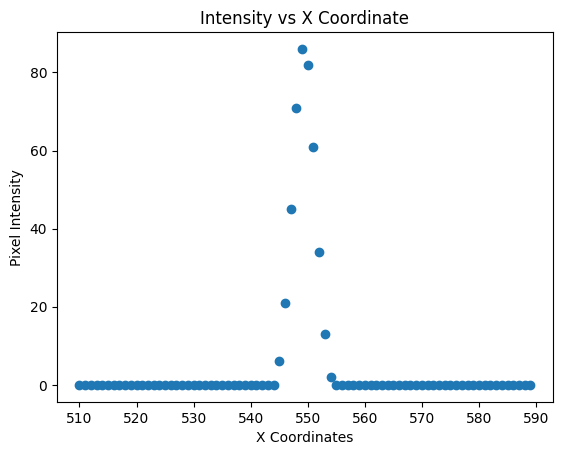

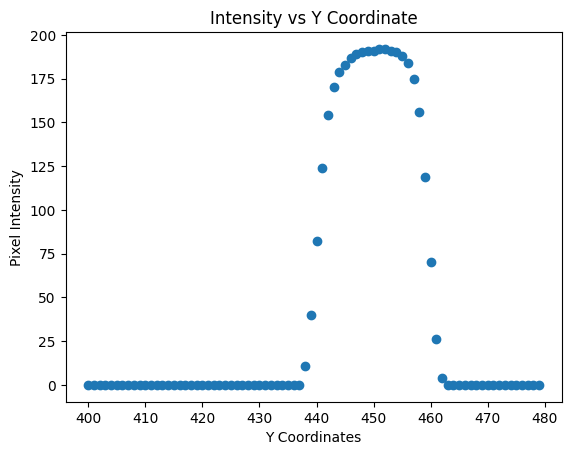

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/128_128_128_X_180000.bmp
Pixel location with intensity > 50:
X: 550
Y: 441
Center X: 750
Center Y: 564


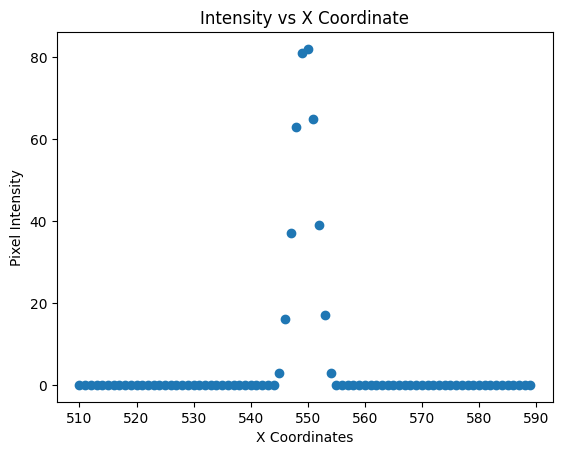

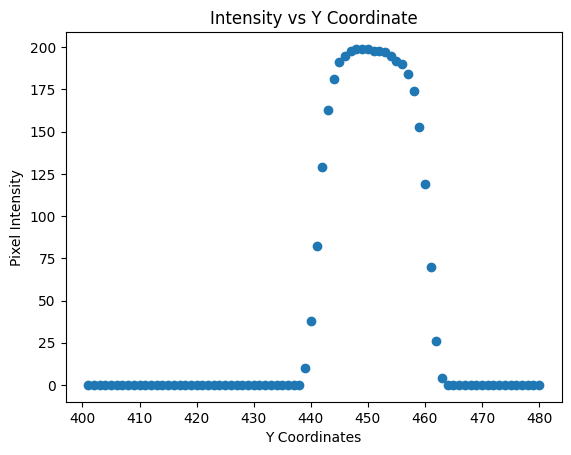

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/128_128_16_clear_180000.bmp
Pixel location with intensity > 50:
X: 550
Y: 440
Center X: 750
Center Y: 564


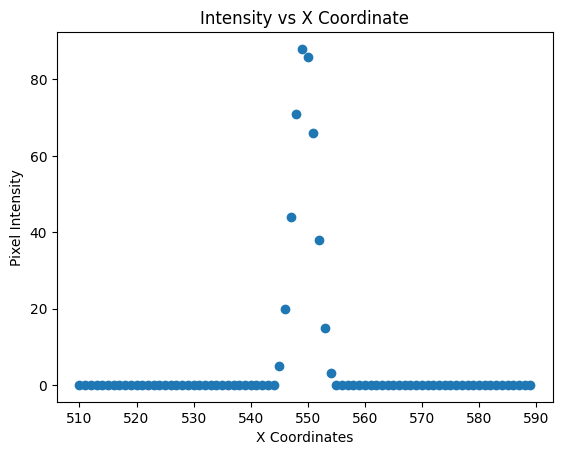

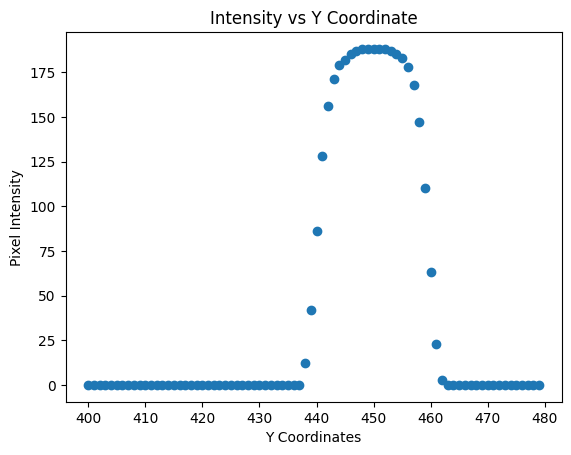

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/128_128_16_X_180000.bmp
Pixel location with intensity > 50:
X: 550
Y: 441
Center X: 750
Center Y: 564


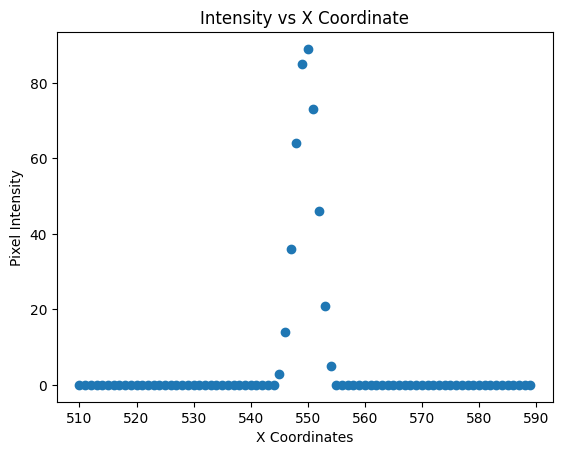

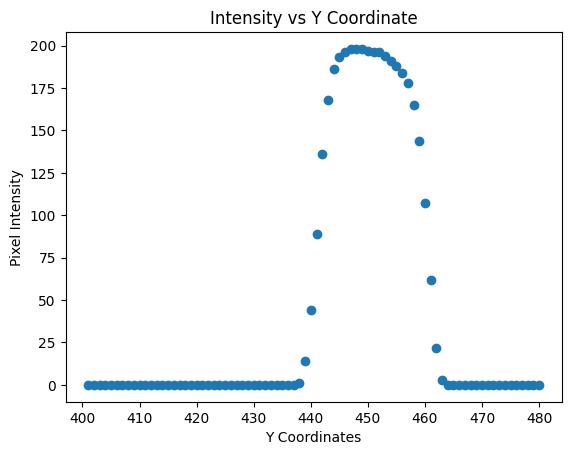

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/128_128_32_clear_180000.bmp
Pixel location with intensity > 50:
X: 550
Y: 440
Center X: 750
Center Y: 564


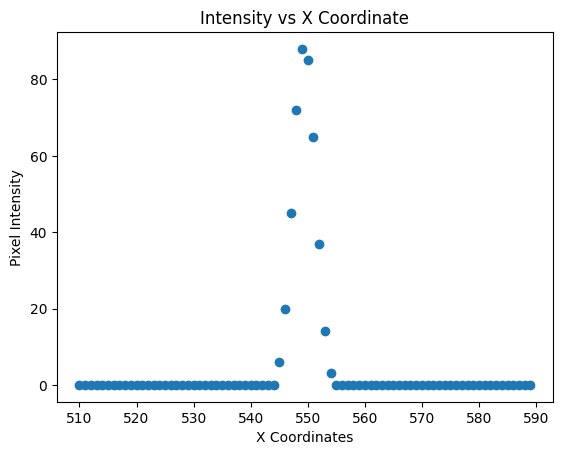

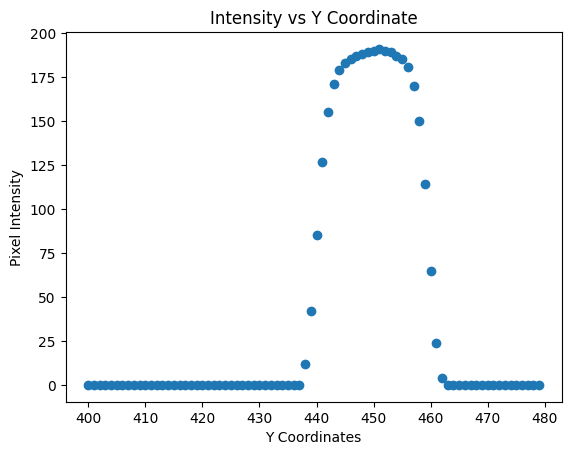

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/128_128_32_X_180000.bmp
Pixel location with intensity > 50:
X: 550
Y: 441
Center X: 750
Center Y: 564


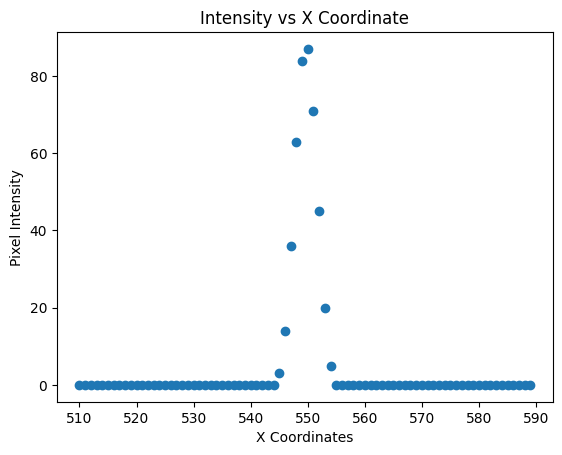

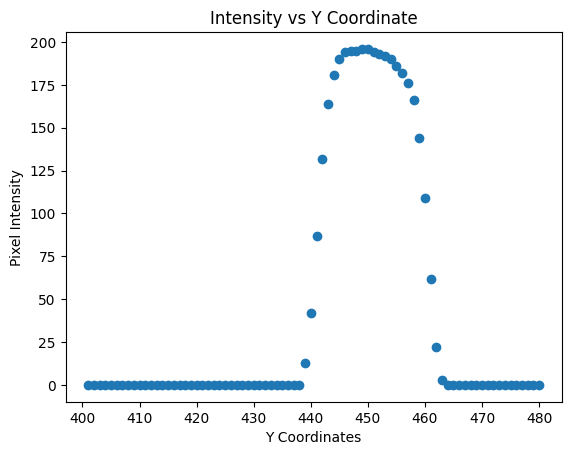

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/128_128_4_clear_180000.bmp
Pixel location with intensity > 50:
X: 550
Y: 440
Center X: 750
Center Y: 564


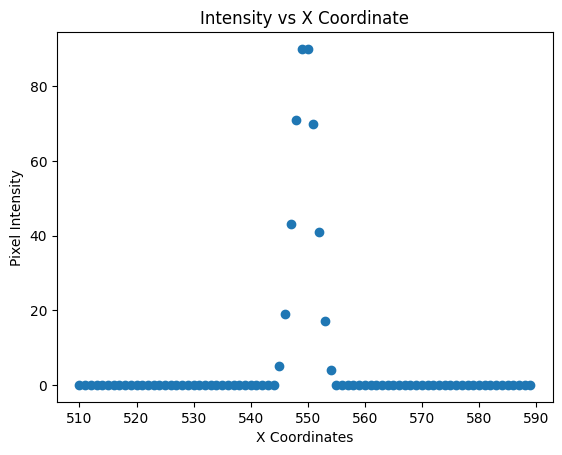

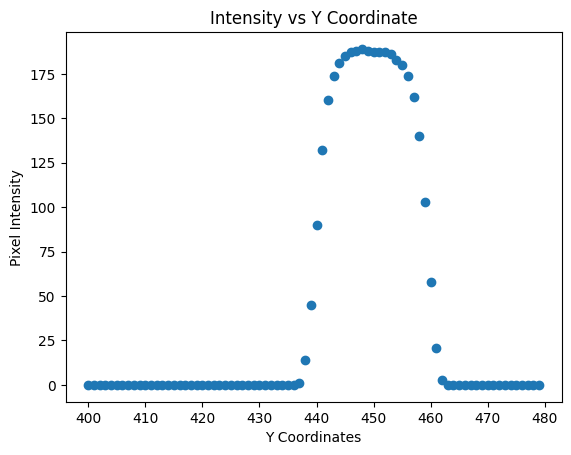

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/128_128_4_X_180000.bmp
Pixel location with intensity > 50:
X: 550
Y: 441
Center X: 750
Center Y: 564


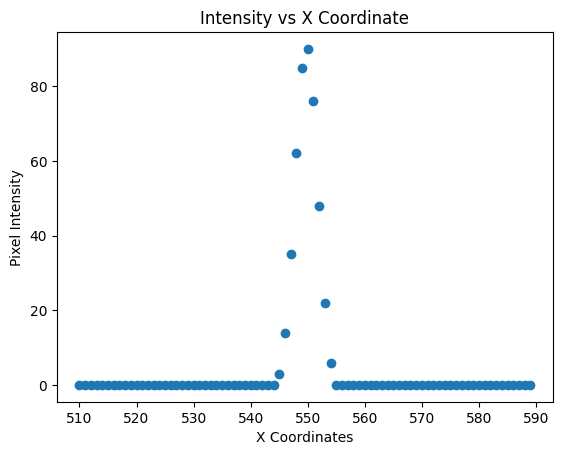

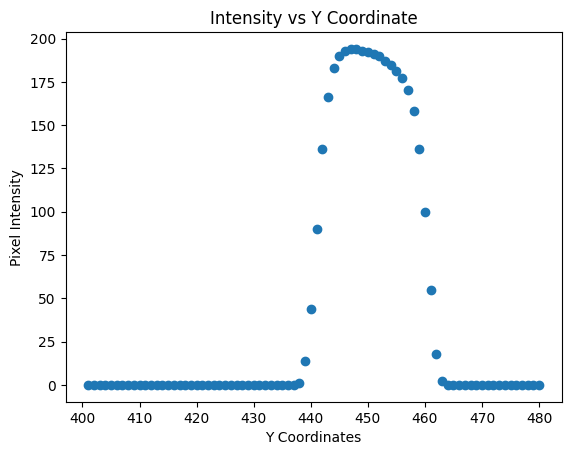

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/128_128_64_clear_180000.bmp
Pixel location with intensity > 50:
X: 550
Y: 387
Center X: 750
Center Y: 564


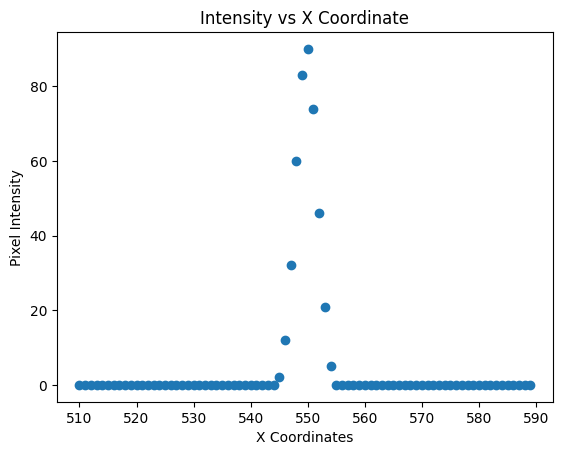

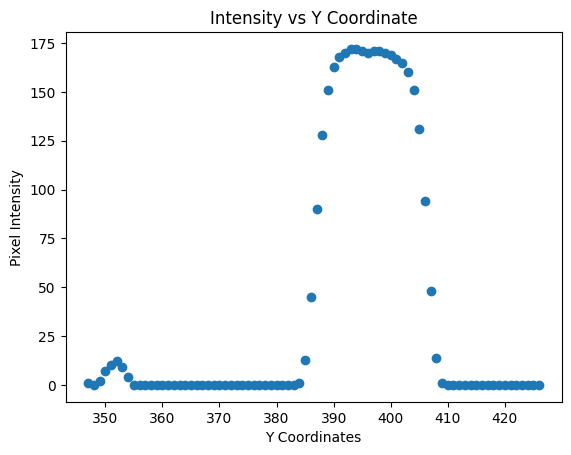

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/128_128_64_X_180000.bmp
Pixel location with intensity > 50:
X: 550
Y: 388
Center X: 750
Center Y: 564


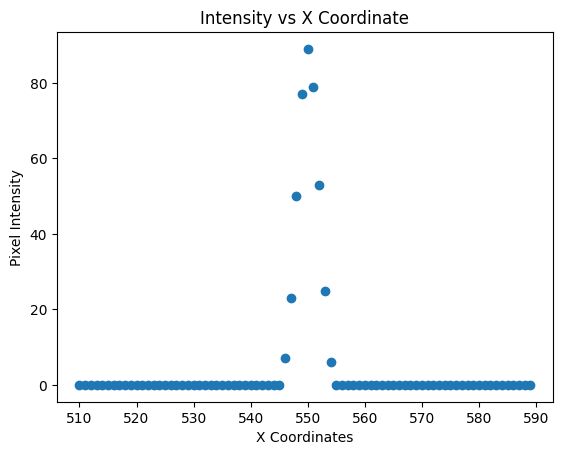

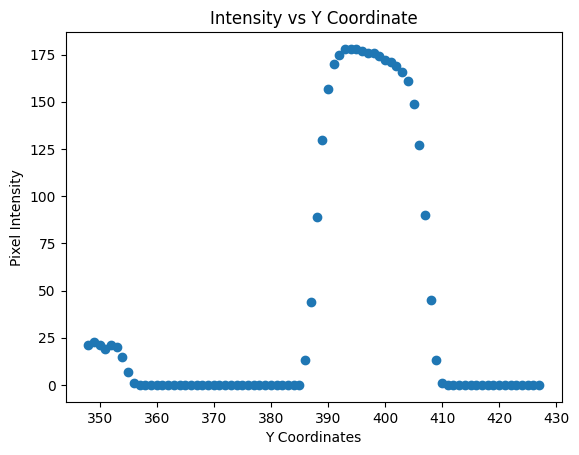

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/128_128_8_clear_180000.bmp
Pixel location with intensity > 50:
X: 550
Y: 387
Center X: 750
Center Y: 564


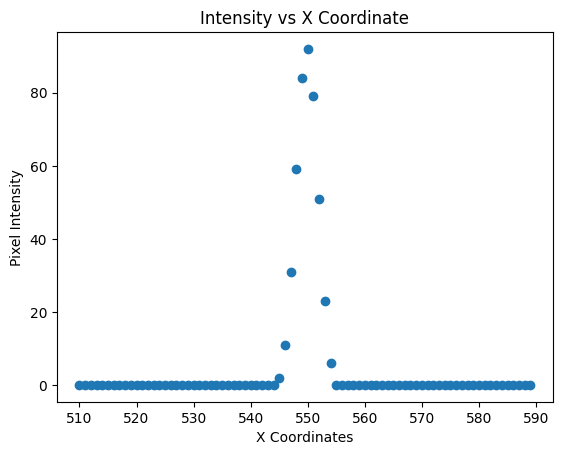

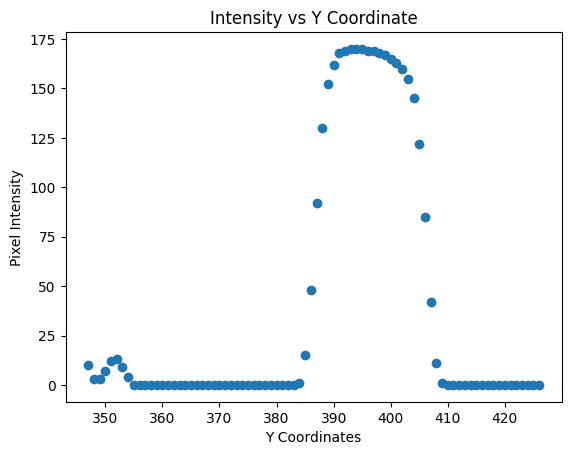

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/128_128_8_X_180000.bmp
Pixel location with intensity > 50:
X: 550
Y: 388
Center X: 750
Center Y: 564


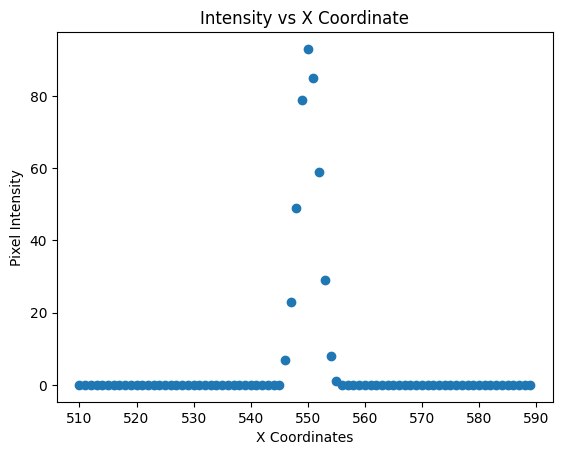

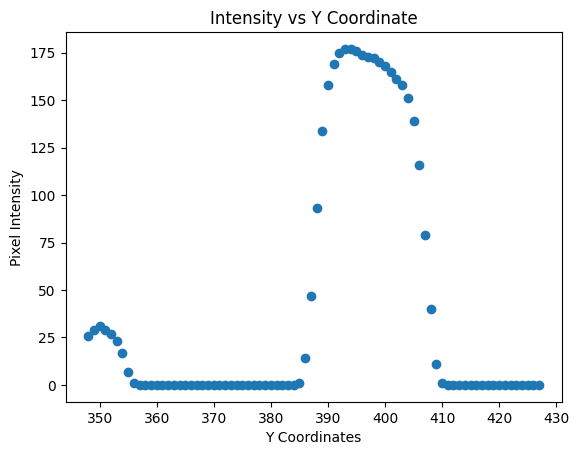

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/128_16_128_clear_180000.bmp
Pixel location with intensity > 50:
X: 550
Y: 386
Center X: 750
Center Y: 564


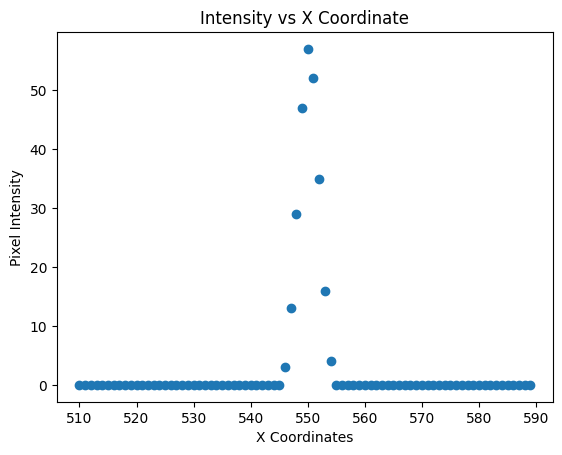

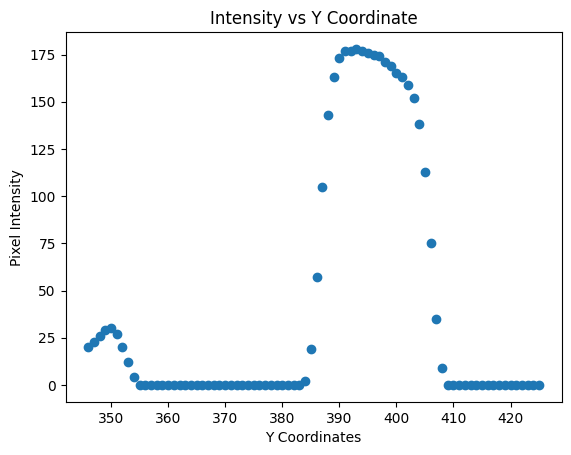

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/128_16_128_X_180000.bmp
Pixel location with intensity > 50:
X: 550
Y: 387
Center X: 750
Center Y: 564


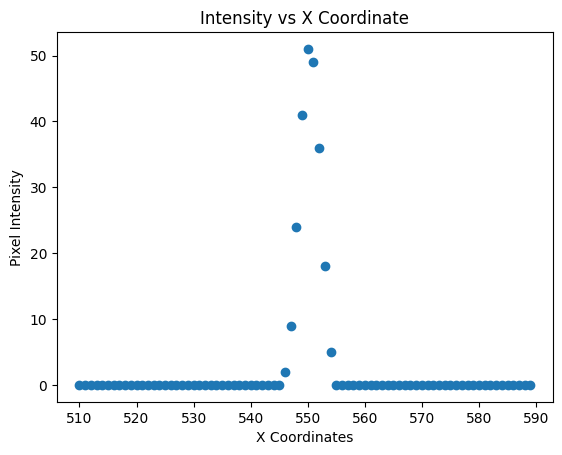

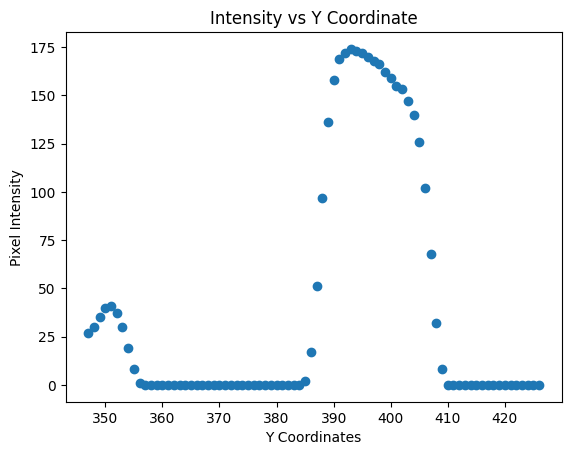

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/128_32_128_clear_180000.bmp
Pixel location with intensity > 50:
X: 550
Y: 628
Center X: 750
Center Y: 564


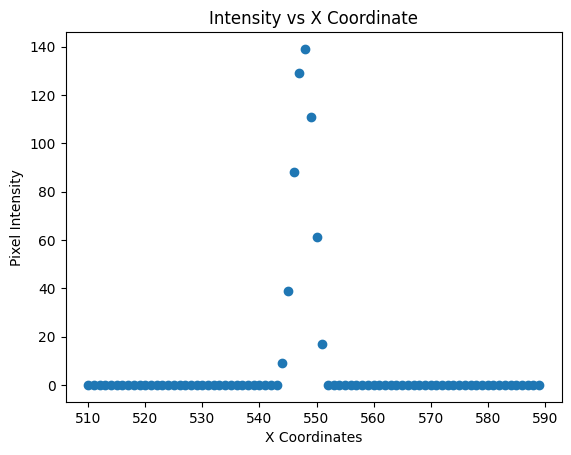

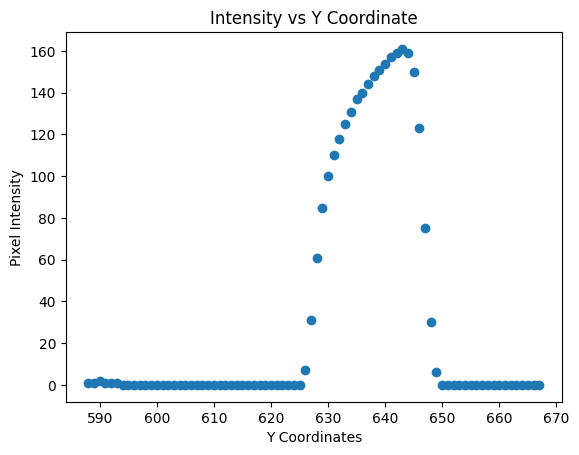

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/128_32_128_X_180000.bmp
Pixel location with intensity > 50:
X: 550
Y: 629
Center X: 750
Center Y: 564


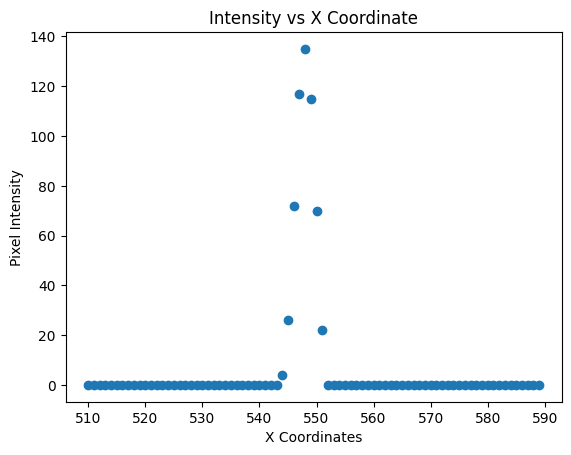

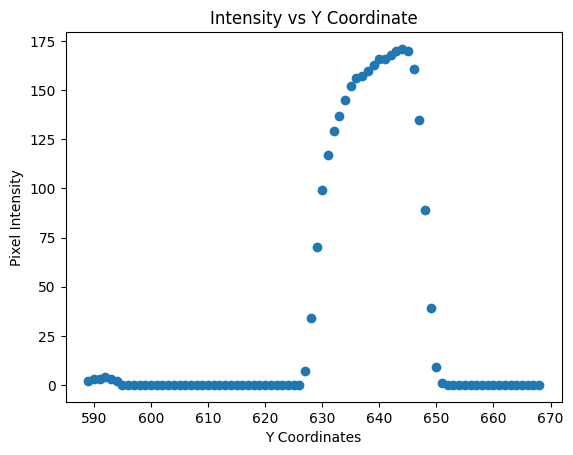

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/128_4_128_clear_180000.bmp
Pixel location with intensity > 50:
X: 550
Y: 628
Center X: 750
Center Y: 564


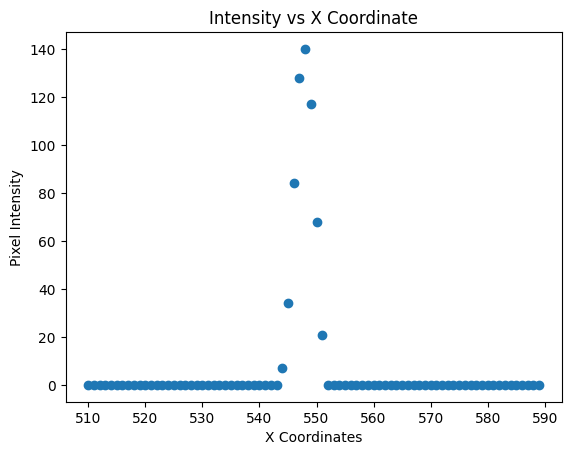

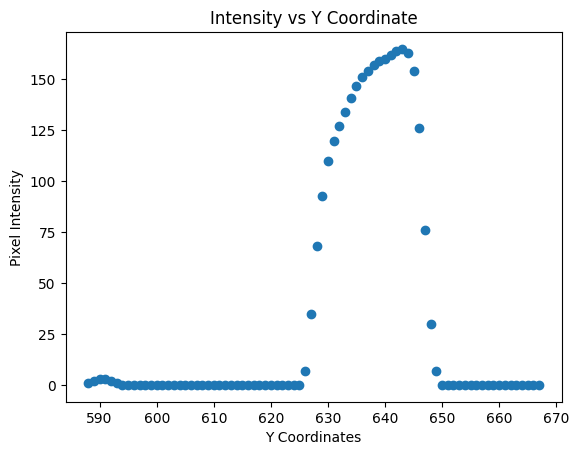

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/128_4_128_X_180000.bmp
Pixel location with intensity > 50:
X: 550
Y: 629
Center X: 750
Center Y: 564


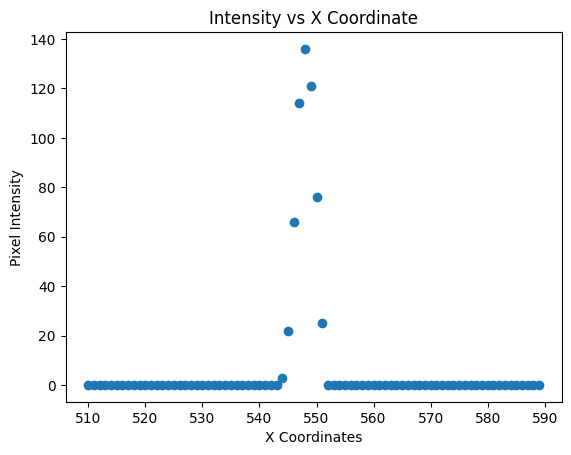

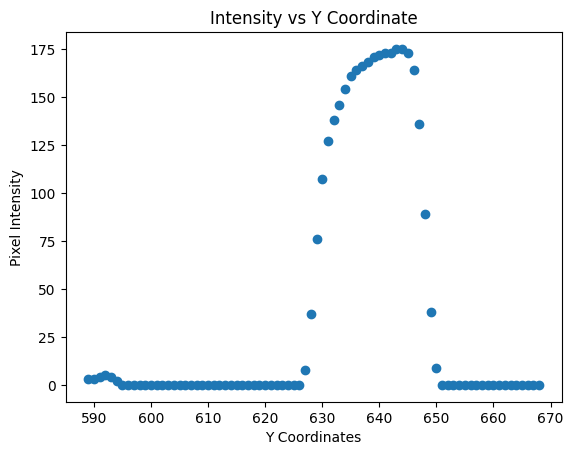

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/128_64_128_clear_180000.bmp
Pixel location with intensity > 50:
X: 550
Y: 628
Center X: 750
Center Y: 564


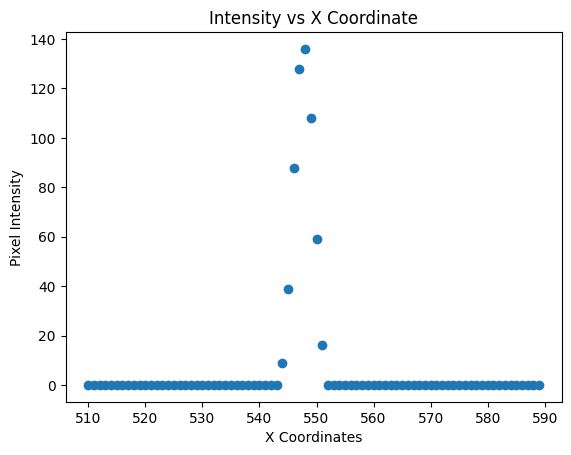

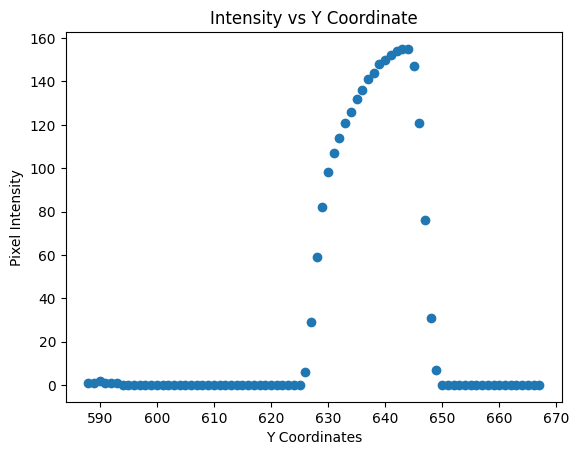

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/128_64_128_X_180000.bmp
Pixel location with intensity > 50:
X: 550
Y: 629
Center X: 750
Center Y: 564


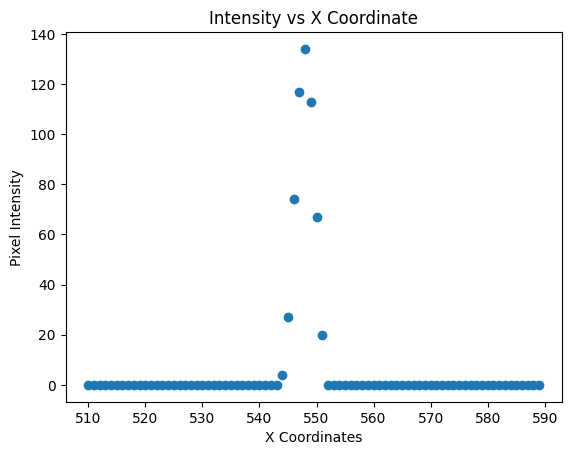

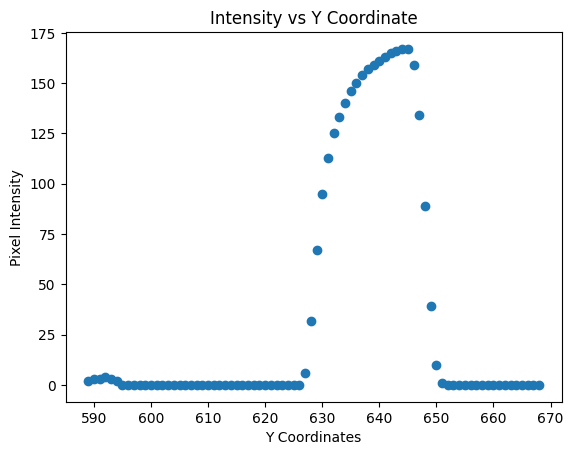

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/128_8_128_clear_180000.bmp
Pixel location with intensity > 50:
X: 550
Y: 628
Center X: 750
Center Y: 564


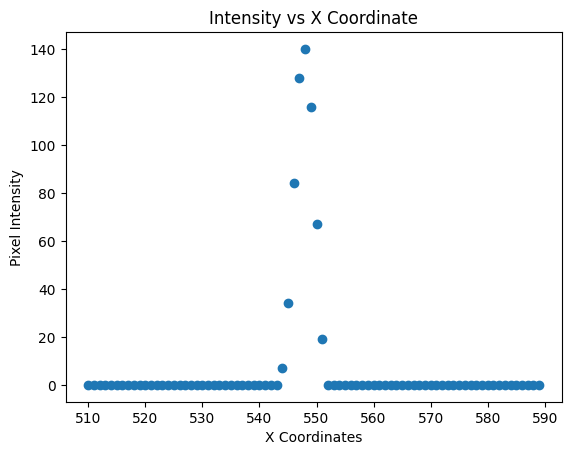

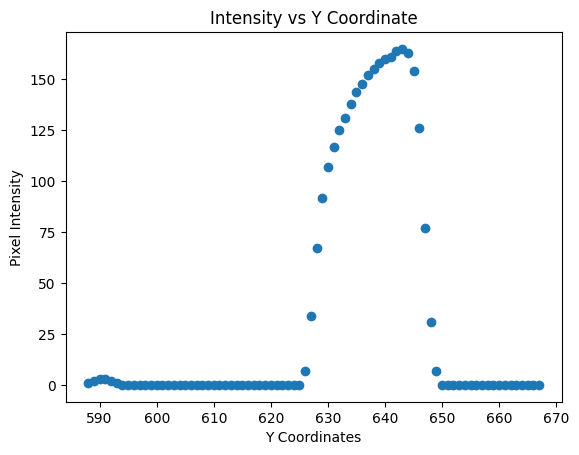

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/128_8_128_X_180000.bmp
Pixel location with intensity > 50:
X: 550
Y: 629
Center X: 750
Center Y: 564


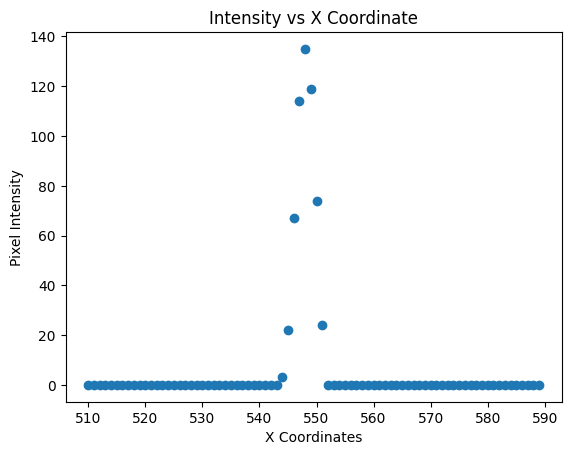

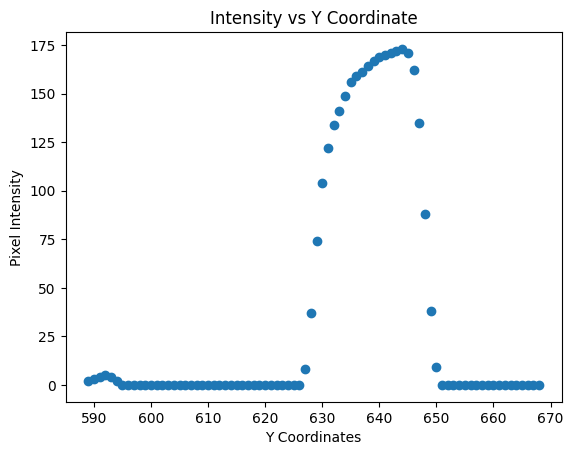

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/16_128_16_clear_14500000.bmp
Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/16_128_16_X_14500000.bmp
Pixel location with intensity > 50:
X: 550
Y: 684
Center X: 750
Center Y: 564


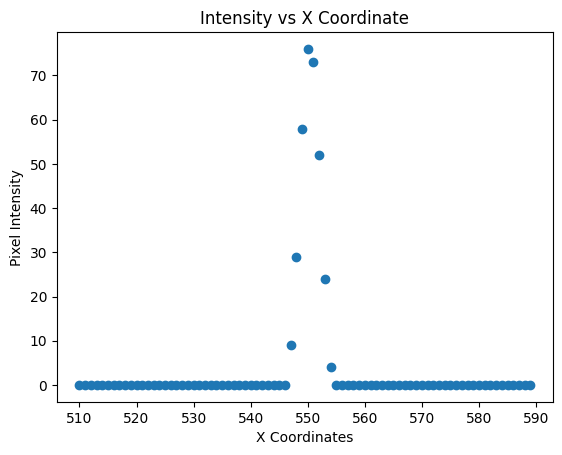

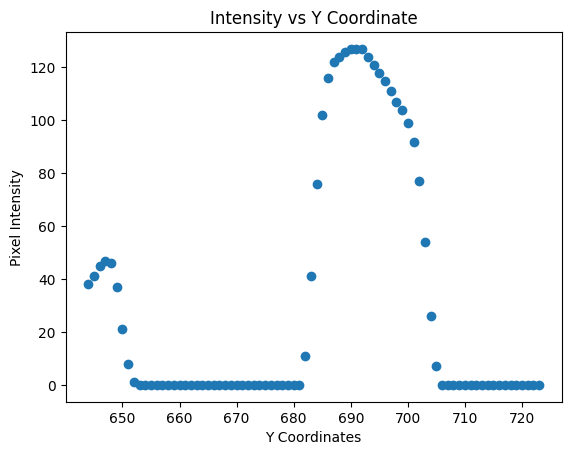

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/16_16_128_clear_14500000.bmp
Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/16_16_128_X_14500000.bmp
Pixel location with intensity > 50:
X: 550
Y: 684
Center X: 750
Center Y: 564


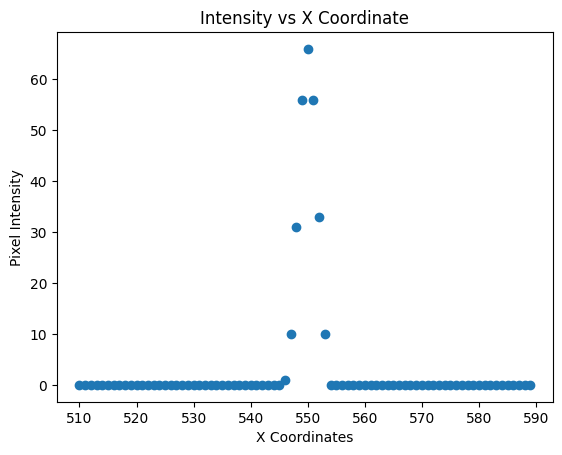

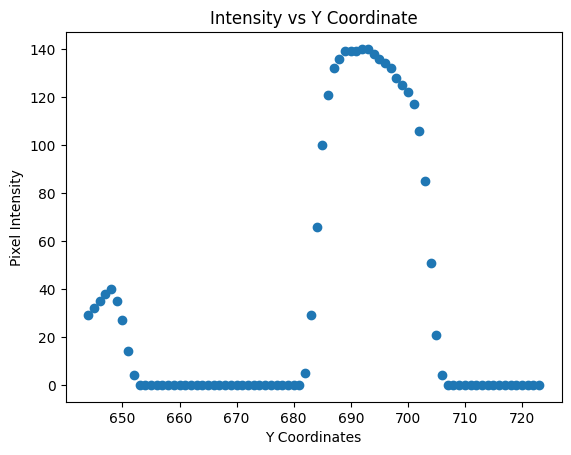

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/16_16_16_clear_14500000.bmp
Pixel location with intensity > 50:
X: 550
Y: 645
Center X: 750
Center Y: 564


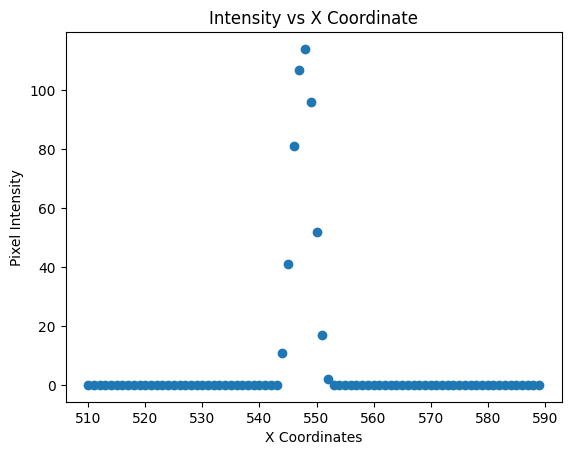

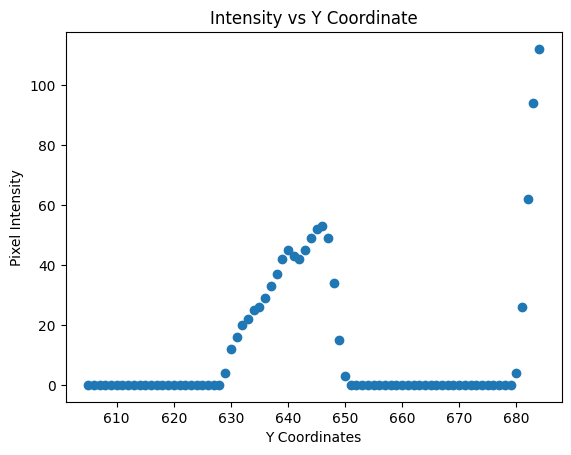

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/16_16_16_X_14500000.bmp
Pixel location with intensity > 50:
X: 550
Y: 684
Center X: 750
Center Y: 564


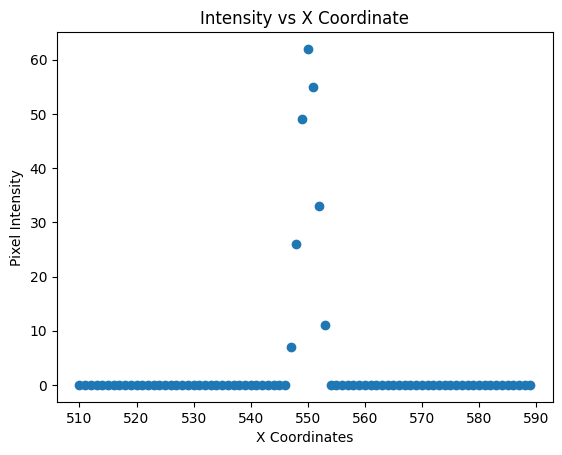

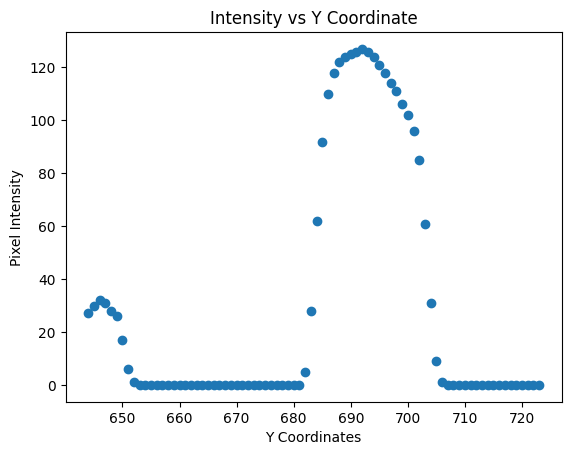

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/16_16_32_clear_14500000.bmp
Pixel location with intensity > 50:
X: 550
Y: 645
Center X: 750
Center Y: 564


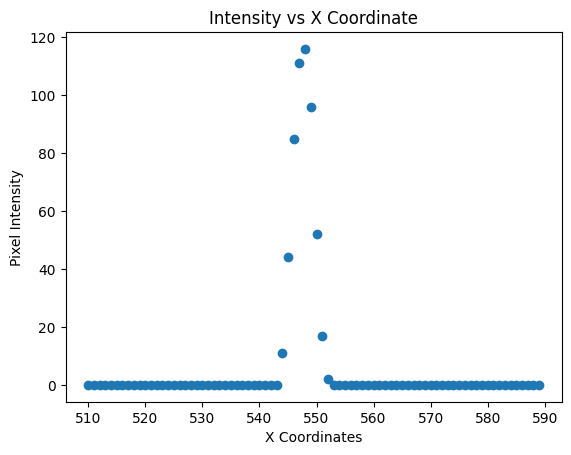

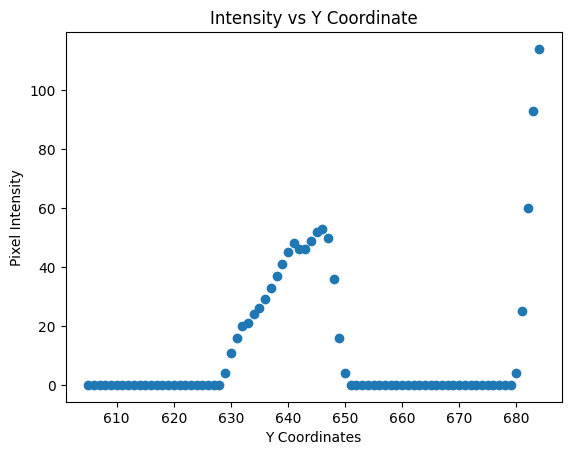

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/16_16_32_X_14500000.bmp
Pixel location with intensity > 50:
X: 550
Y: 684
Center X: 750
Center Y: 564


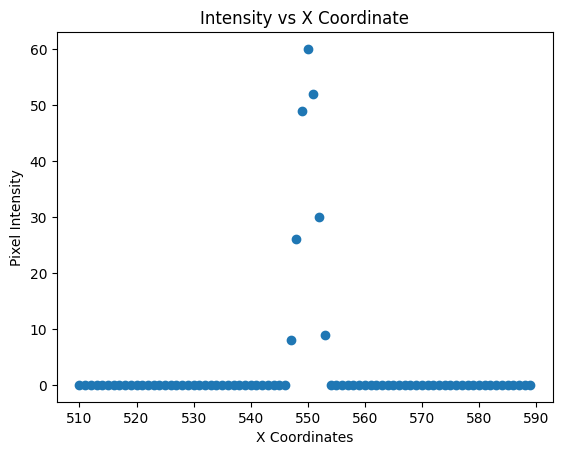

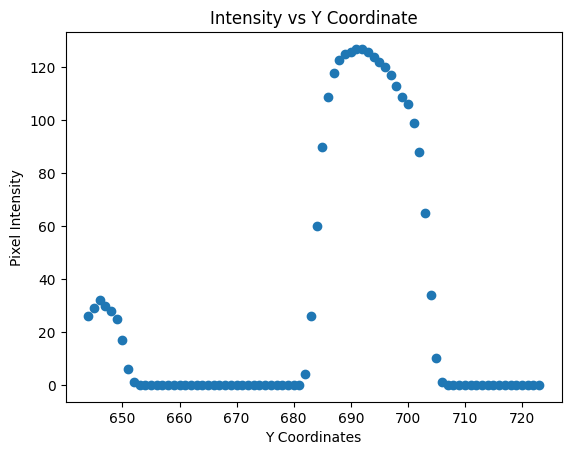

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/16_16_4_clear_14500000.bmp
Pixel location with intensity > 50:
X: 550
Y: 645
Center X: 750
Center Y: 564


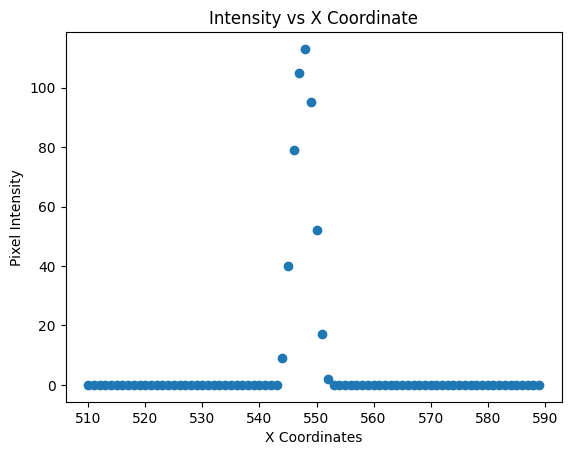

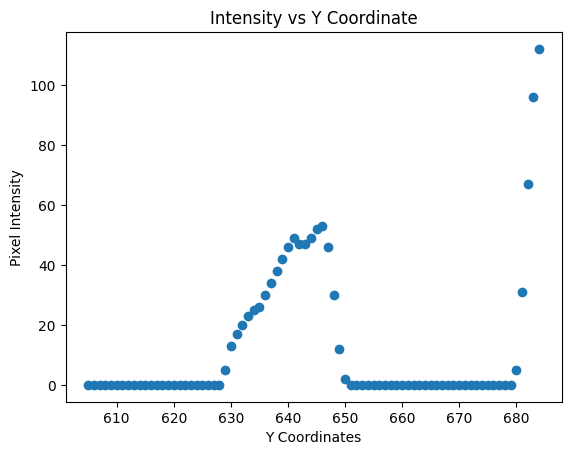

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/16_16_4_X_14500000.bmp
Pixel location with intensity > 50:
X: 550
Y: 684
Center X: 750
Center Y: 564


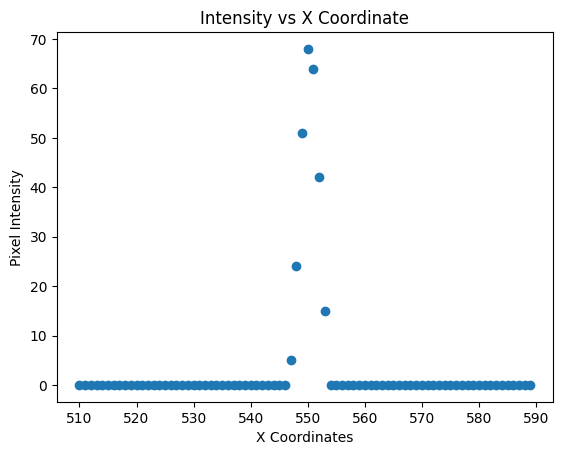

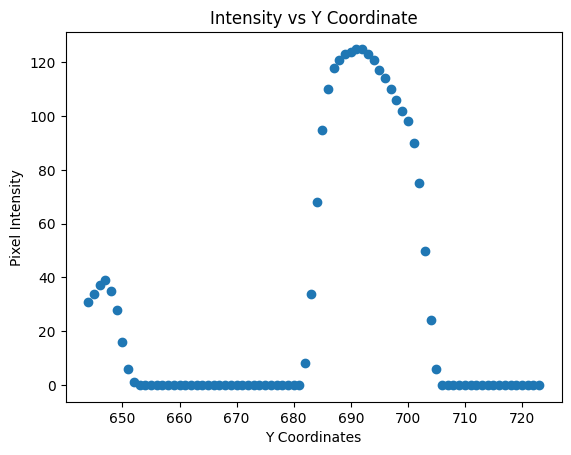

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/16_16_64_clear_14500000.bmp
Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/16_16_64_X_14500000.bmp
Pixel location with intensity > 50:
X: 550
Y: 684
Center X: 750
Center Y: 564


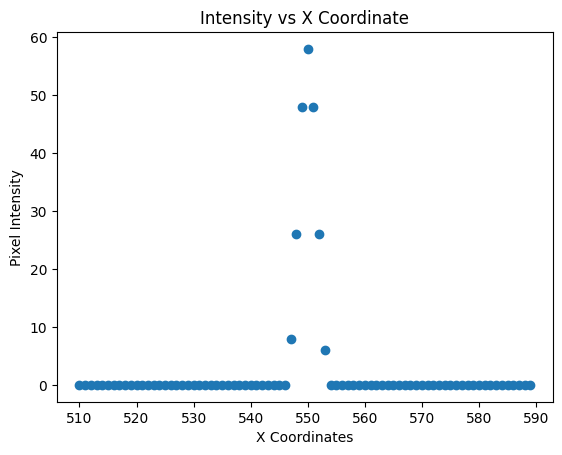

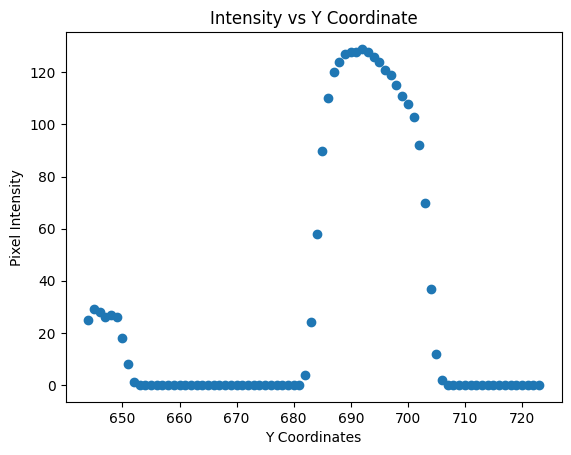

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/16_16_8_clear_14500000.bmp
Pixel location with intensity > 50:
X: 550
Y: 645
Center X: 750
Center Y: 564


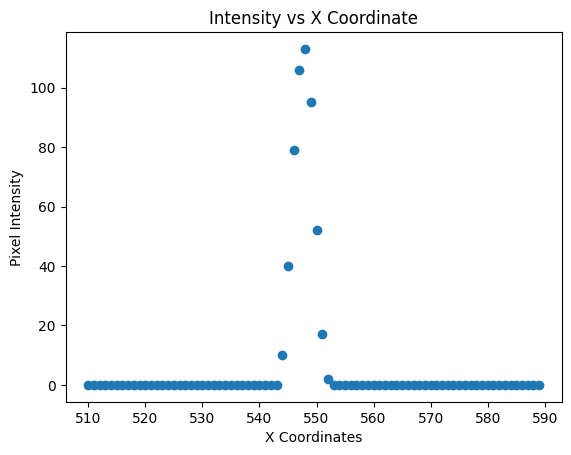

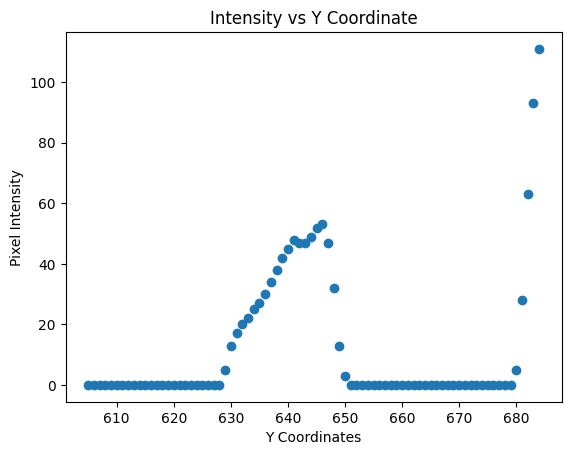

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/16_16_8_X_14500000.bmp
Pixel location with intensity > 50:
X: 550
Y: 684
Center X: 750
Center Y: 564


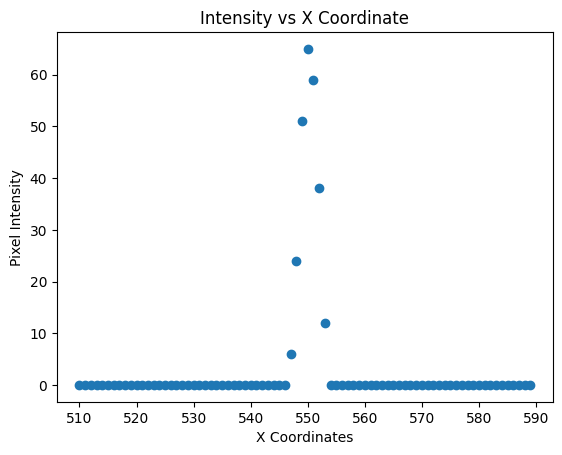

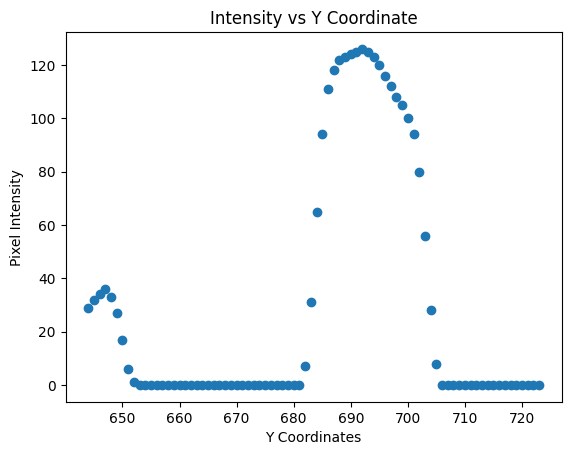

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/16_32_16_clear_14500000.bmp
Pixel location with intensity > 50:
X: 550
Y: 641
Center X: 750
Center Y: 564


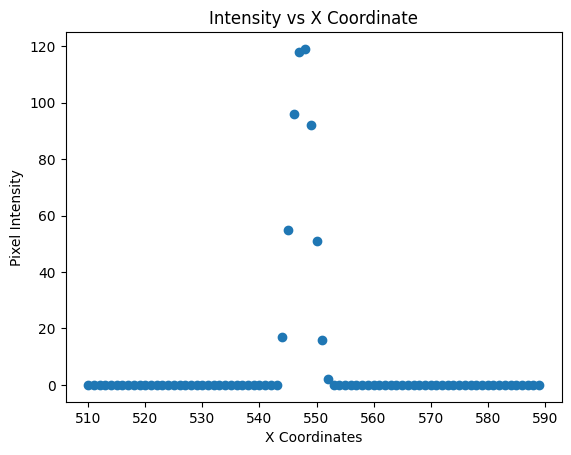

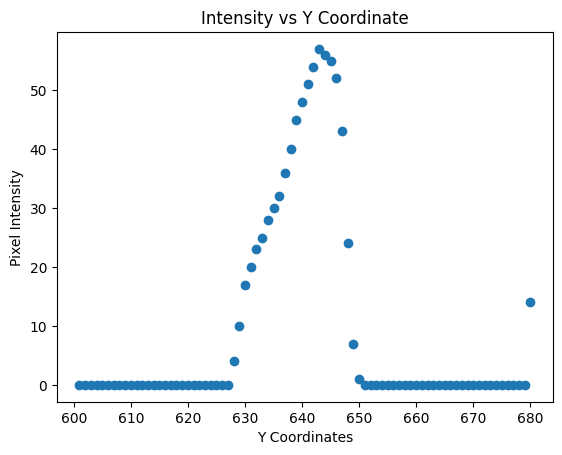

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/16_32_16_X_14500000.bmp
Pixel location with intensity > 50:
X: 550
Y: 684
Center X: 750
Center Y: 564


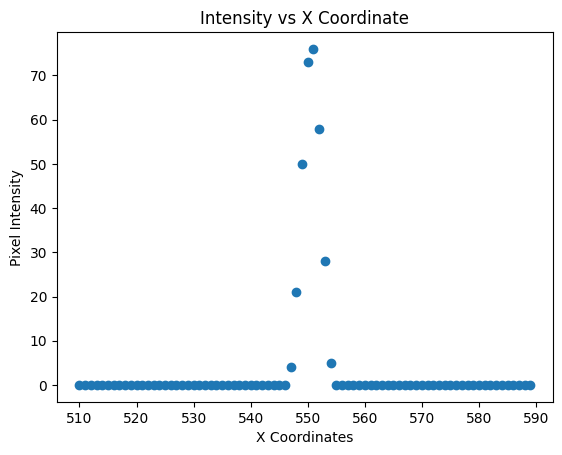

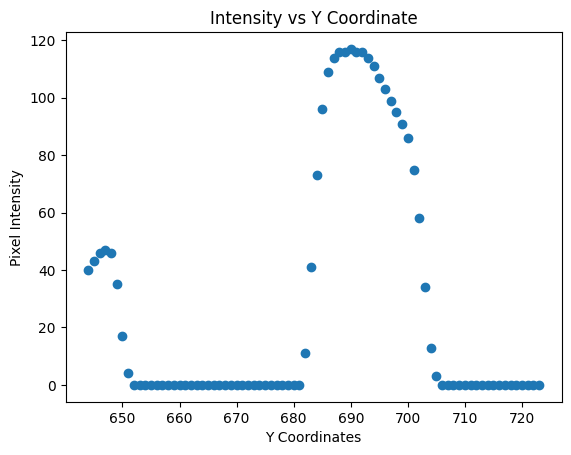

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/16_4_16_clear_14500000.bmp
Pixel location with intensity > 50:
X: 550
Y: 639
Center X: 750
Center Y: 564


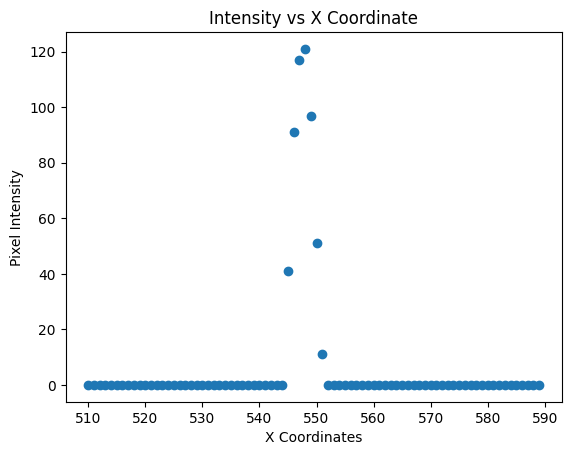

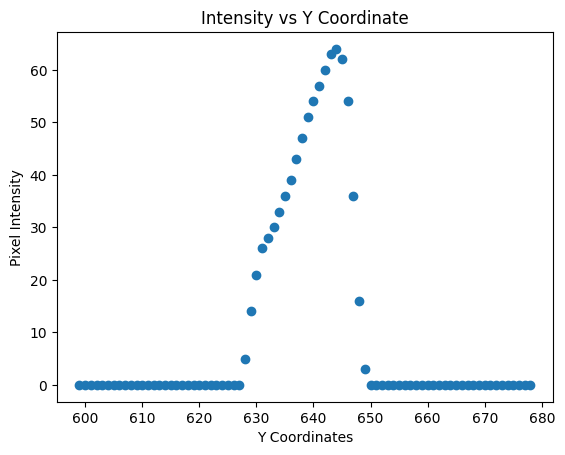

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/16_4_16_X_14500000.bmp
Pixel location with intensity > 50:
X: 550
Y: 640
Center X: 750
Center Y: 564


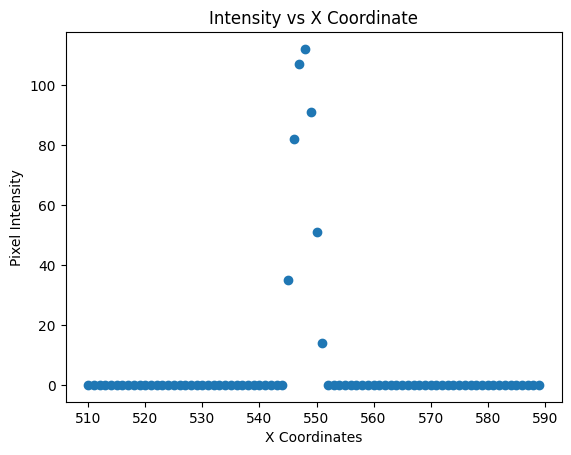

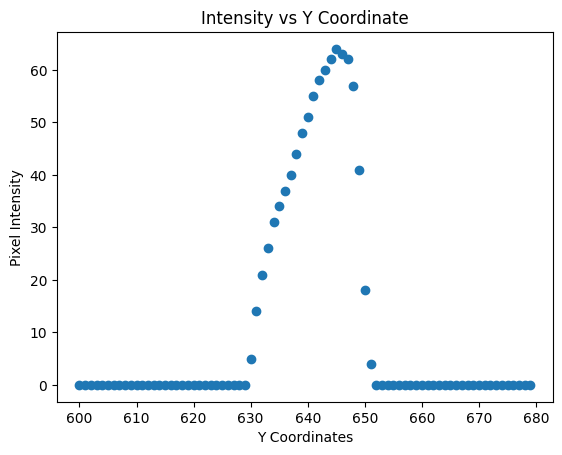

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/16_64_16_clear_14500000.bmp
Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/16_64_16_X_14500000.bmp
Pixel location with intensity > 50:
X: 550
Y: 684
Center X: 750
Center Y: 564


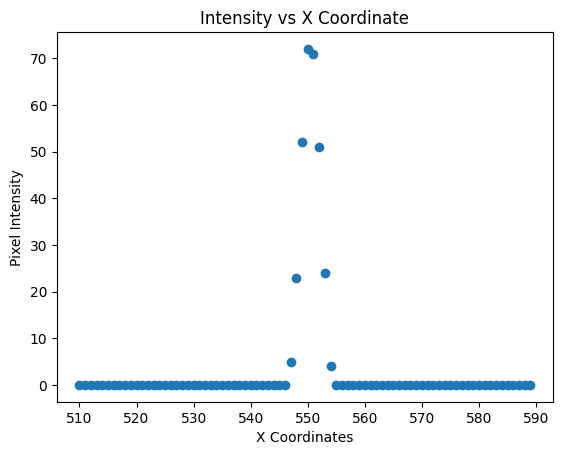

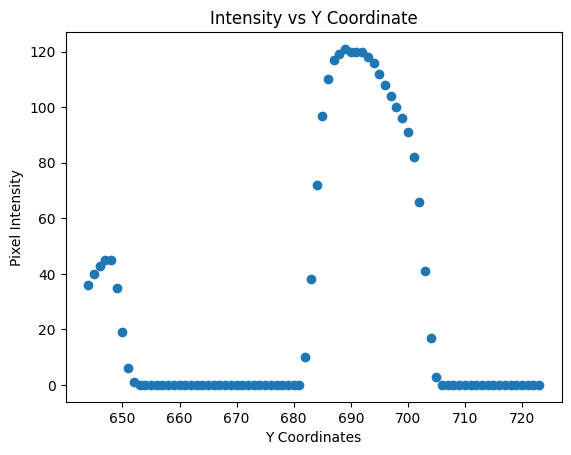

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/16_8_16_clear_14500000.bmp
Pixel location with intensity > 50:
X: 550
Y: 641
Center X: 750
Center Y: 564


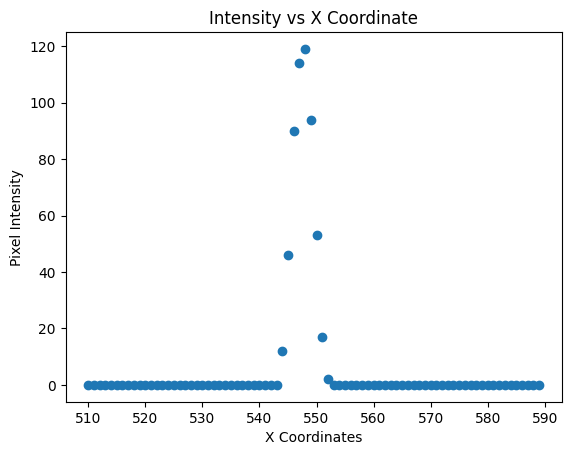

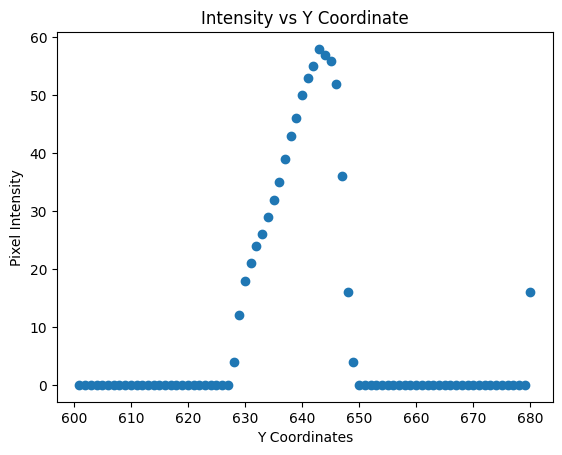

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/16_8_16_X_14500000.bmp
Pixel location with intensity > 50:
X: 550
Y: 642
Center X: 750
Center Y: 564


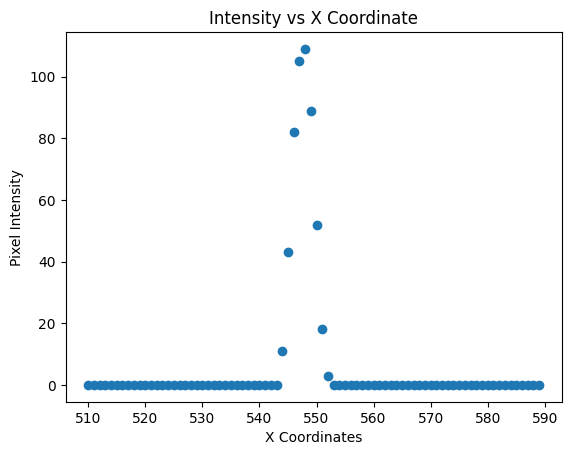

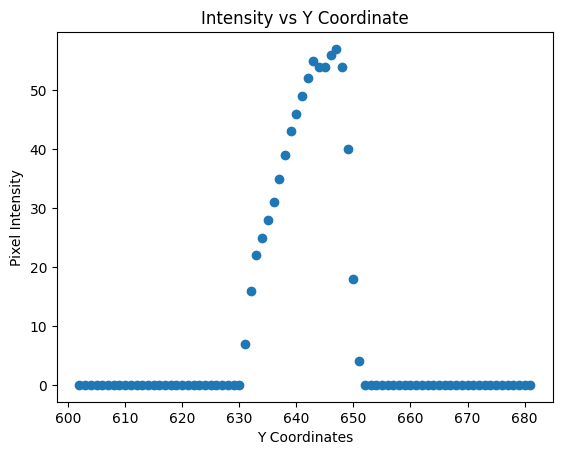

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/32_128_32_clear_3600000.bmp
Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/32_128_32_X_3600000.bmp
Pixel location with intensity > 50:
X: 550
Y: 681
Center X: 750
Center Y: 564


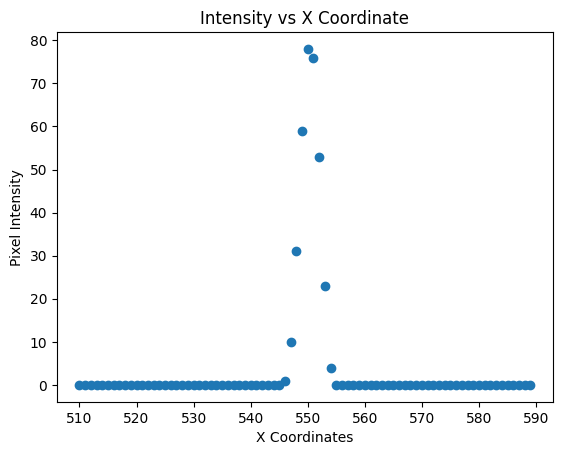

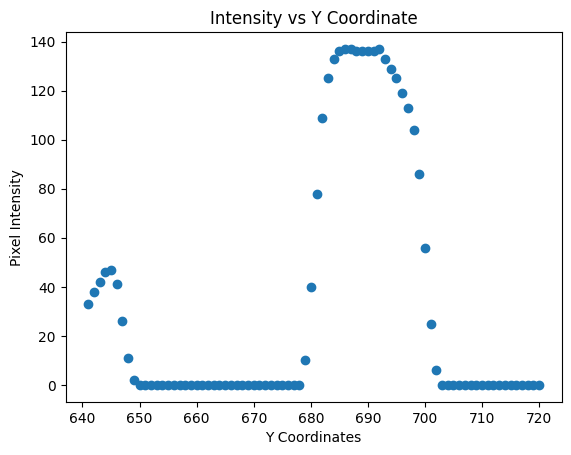

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/32_16_32_clear_3600000.bmp
Pixel location with intensity > 50:
X: 550
Y: 386
Center X: 750
Center Y: 564


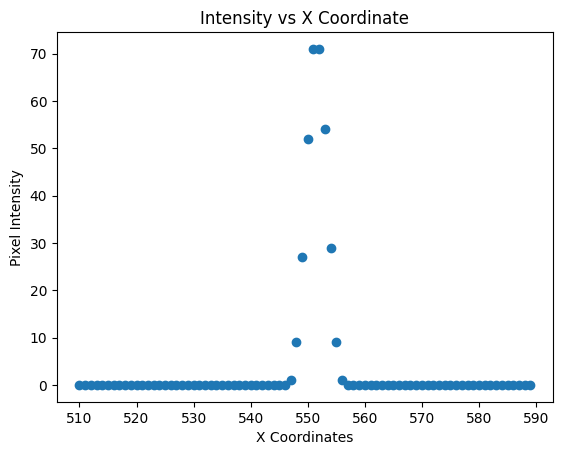

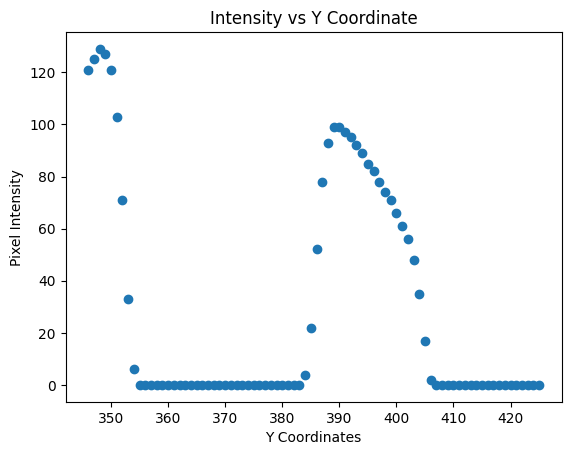

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/32_16_32_X_3600000.bmp
Pixel location with intensity > 50:
X: 550
Y: 681
Center X: 750
Center Y: 564


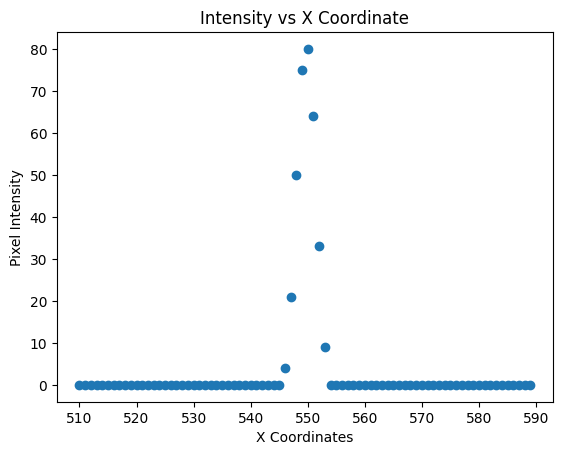

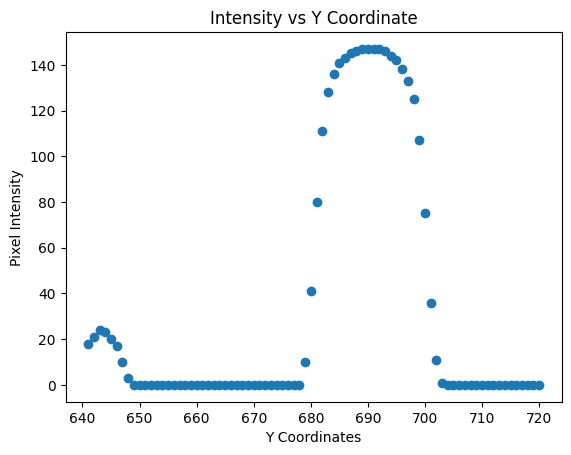

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/32_32_128_clear_3600000.bmp
Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/32_32_128_X_3600000.bmp
Pixel location with intensity > 50:
X: 550
Y: 630
Center X: 750
Center Y: 564


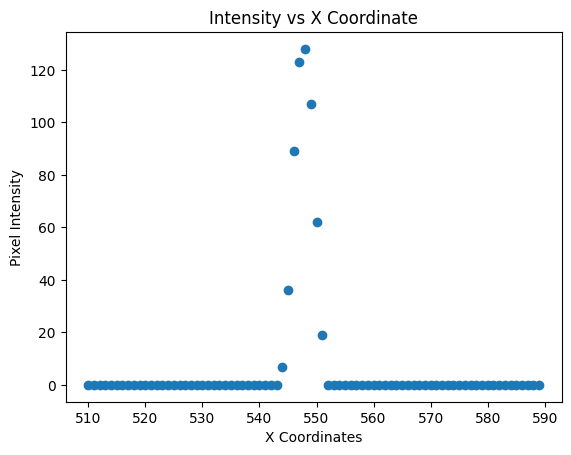

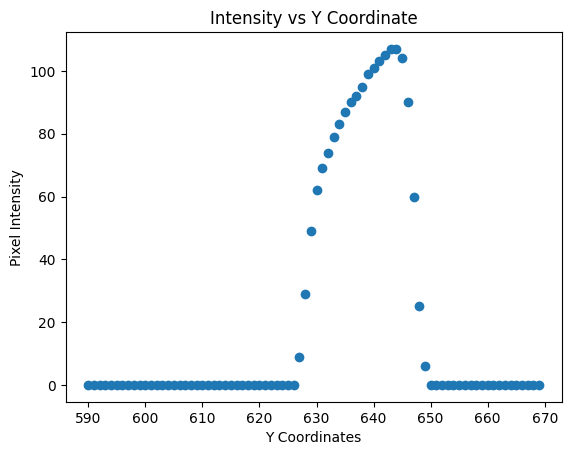

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/32_32_16_clear_3600000.bmp
Pixel location with intensity > 50:
X: 550
Y: 388
Center X: 750
Center Y: 564


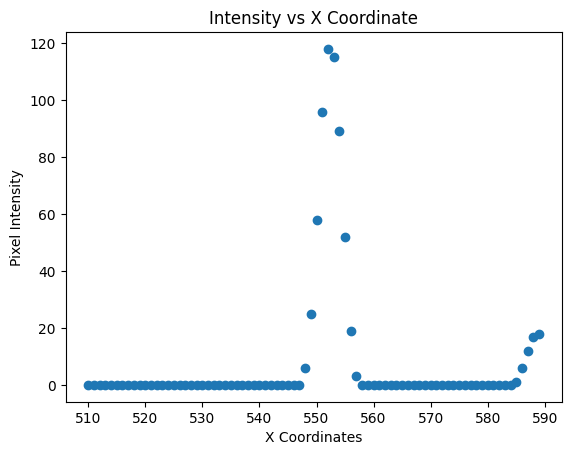

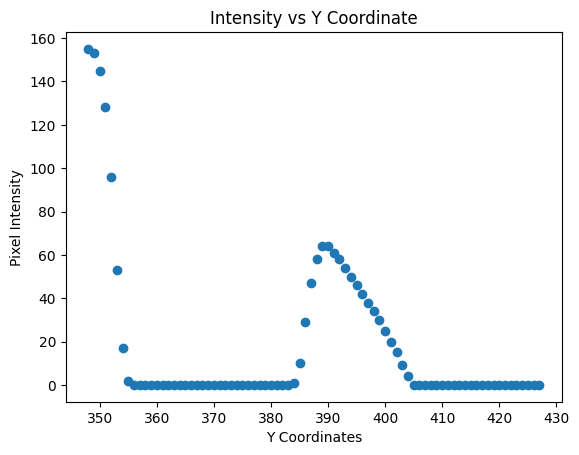

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/32_32_16_X_3600000.bmp
Pixel location with intensity > 50:
X: 550
Y: 636
Center X: 750
Center Y: 564


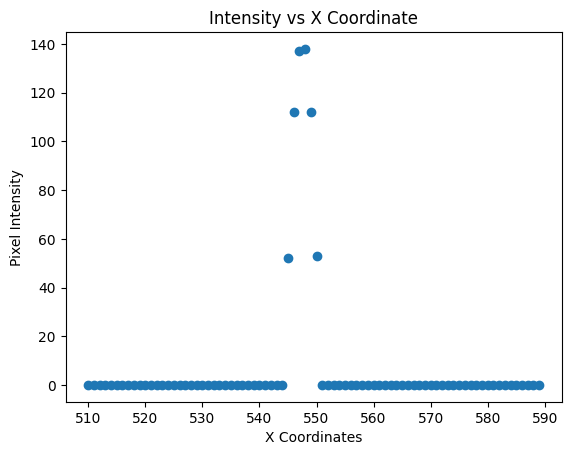

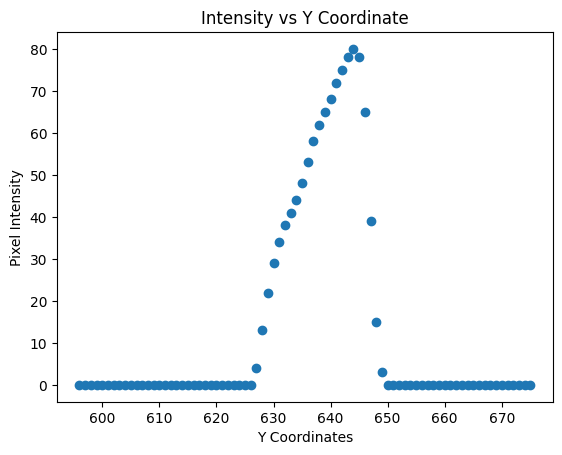

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/32_32_32_clear_3600000.bmp
Pixel location with intensity > 50:
X: 550
Y: 388
Center X: 750
Center Y: 564


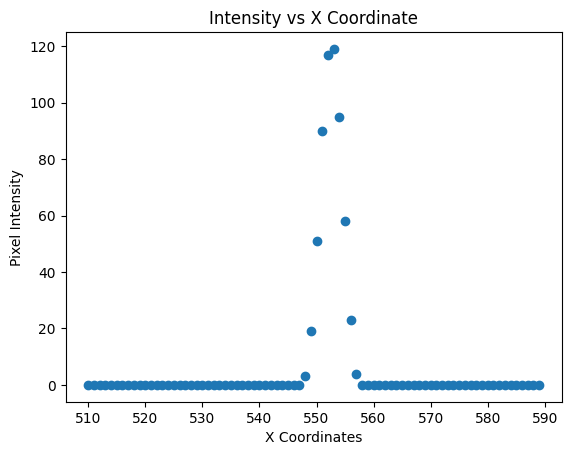

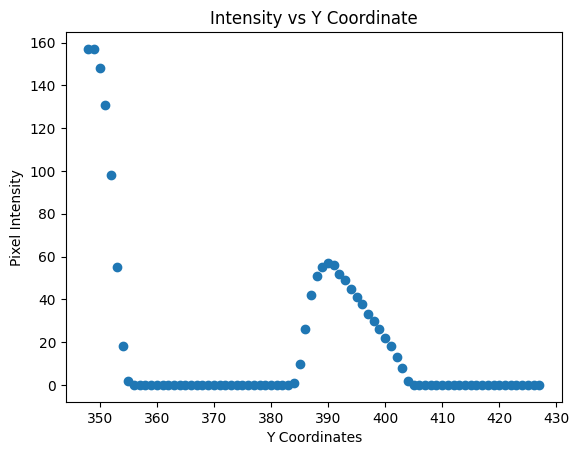

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/32_32_32_X_3600000.bmp
Pixel location with intensity > 50:
X: 550
Y: 634
Center X: 750
Center Y: 564


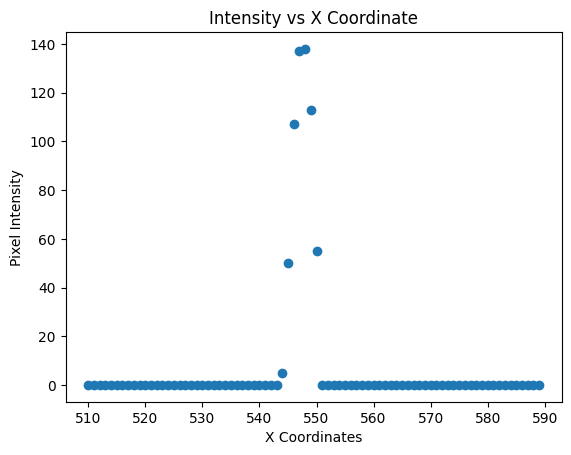

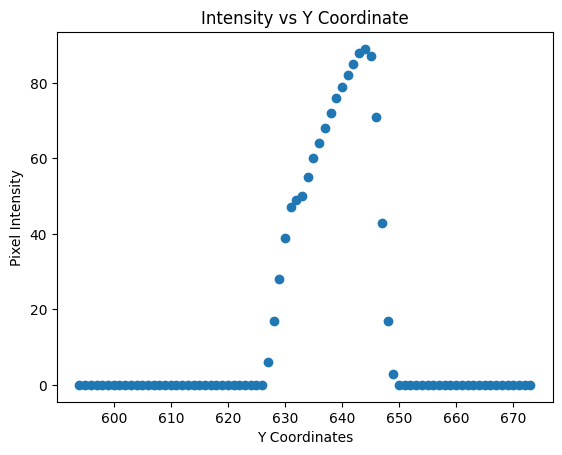

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/32_32_4_clear_3600000.bmp
Pixel location with intensity > 50:
X: 550
Y: 387
Center X: 750
Center Y: 564


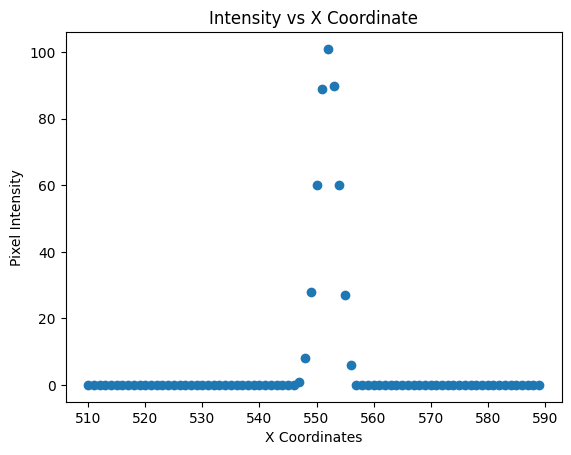

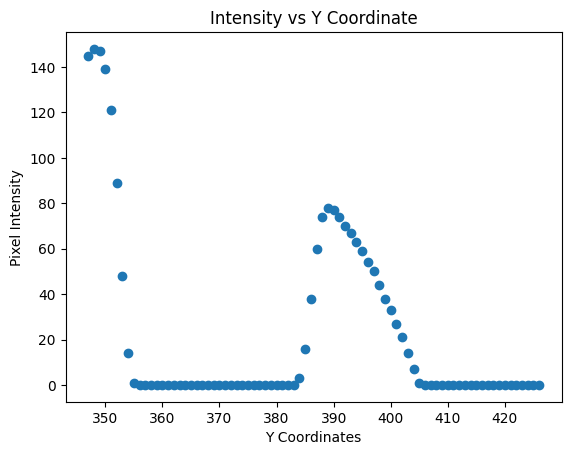

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/32_32_4_X_3600000.bmp
Pixel location with intensity > 50:
X: 550
Y: 641
Center X: 750
Center Y: 564


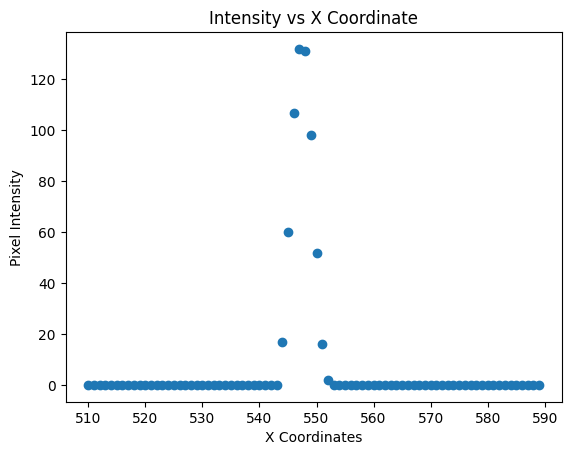

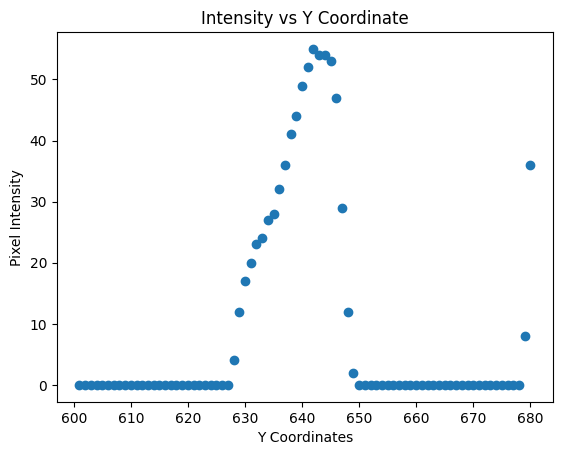

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/32_32_64_clear_3600000.bmp
Pixel location with intensity > 50:
X: 550
Y: 390
Center X: 750
Center Y: 564


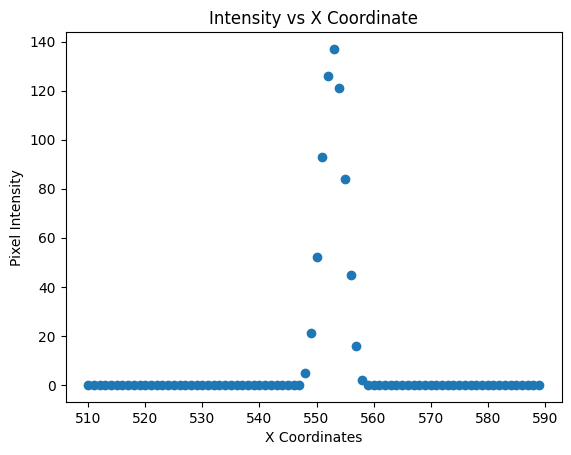

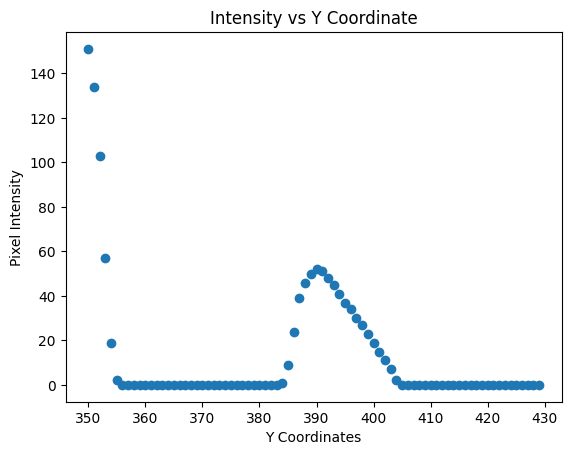

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/32_32_64_X_3600000.bmp
Pixel location with intensity > 50:
X: 550
Y: 630
Center X: 750
Center Y: 564


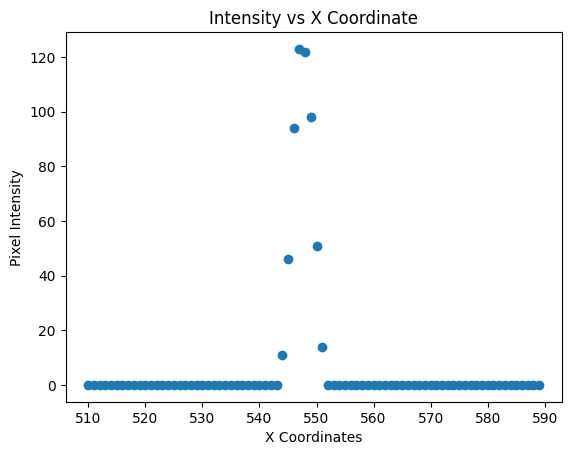

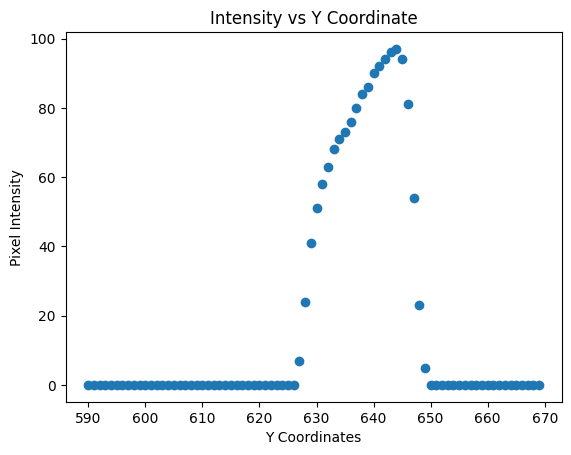

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/32_32_8_clear_3600000.bmp
Pixel location with intensity > 50:
X: 550
Y: 387
Center X: 750
Center Y: 564


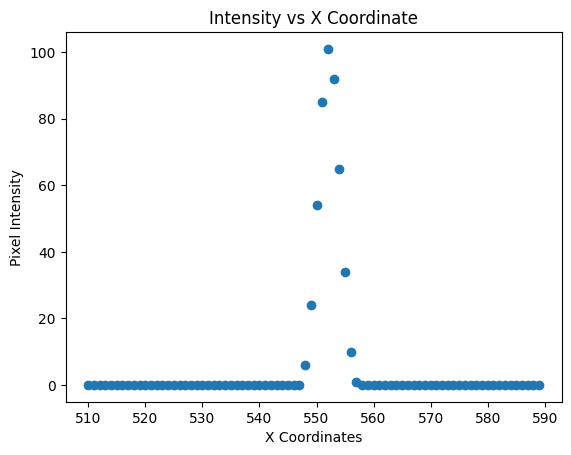

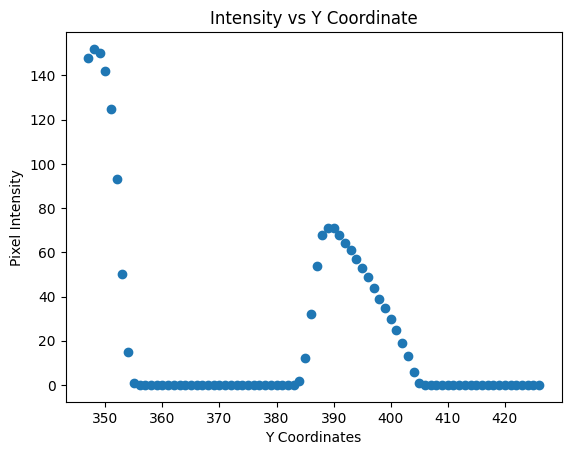

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/32_32_8_X_3600000.bmp
Pixel location with intensity > 50:
X: 550
Y: 638
Center X: 750
Center Y: 564


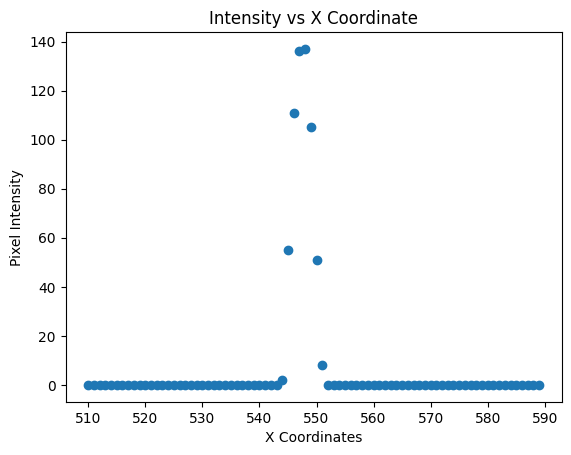

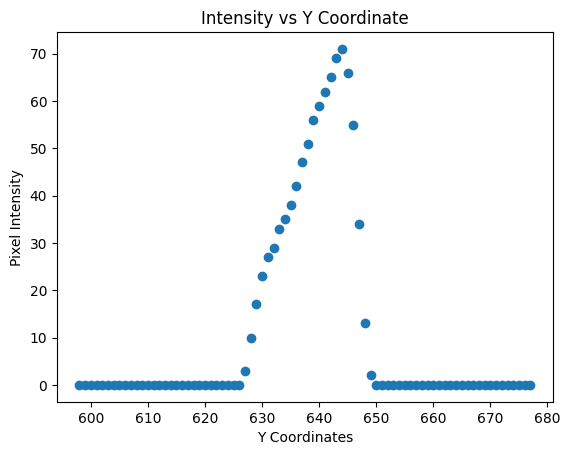

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/32_4_32_clear_3600000.bmp
Pixel location with intensity > 50:
X: 550
Y: 386
Center X: 750
Center Y: 564


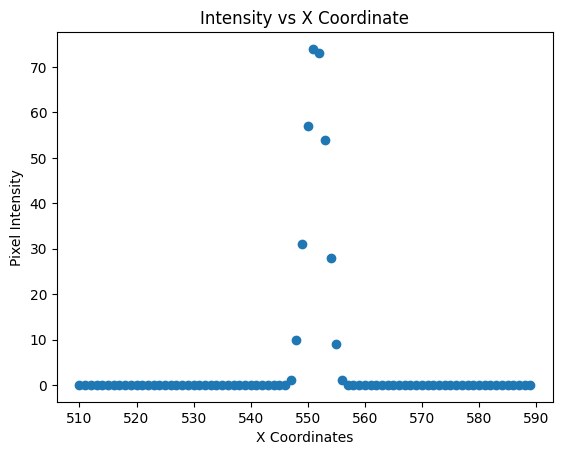

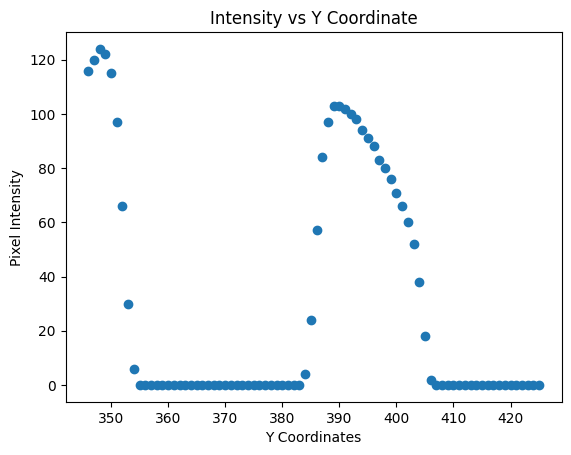

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/32_4_32_X_3600000.bmp
Pixel location with intensity > 50:
X: 550
Y: 681
Center X: 750
Center Y: 564


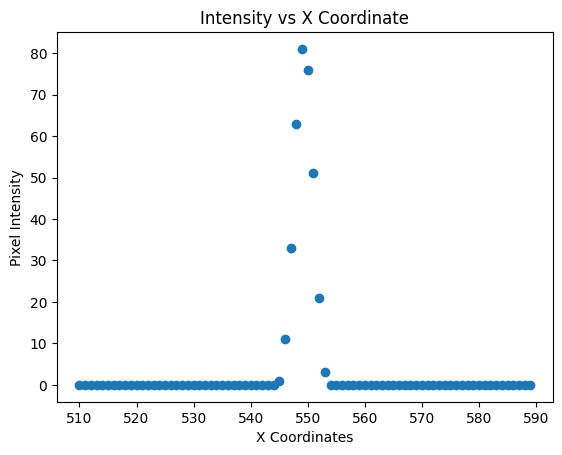

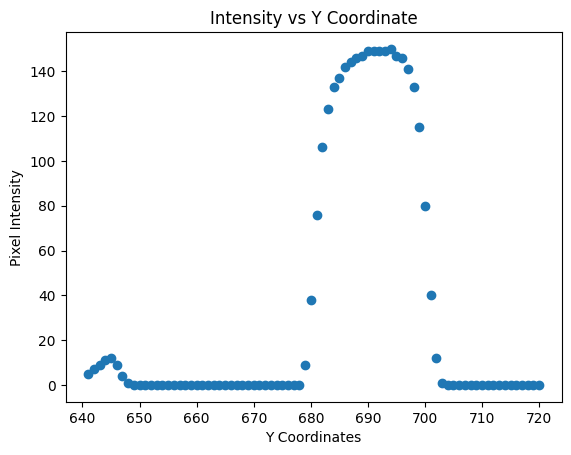

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/32_64_32_clear_3600000.bmp
Pixel location with intensity > 50:
X: 550
Y: 387
Center X: 750
Center Y: 564


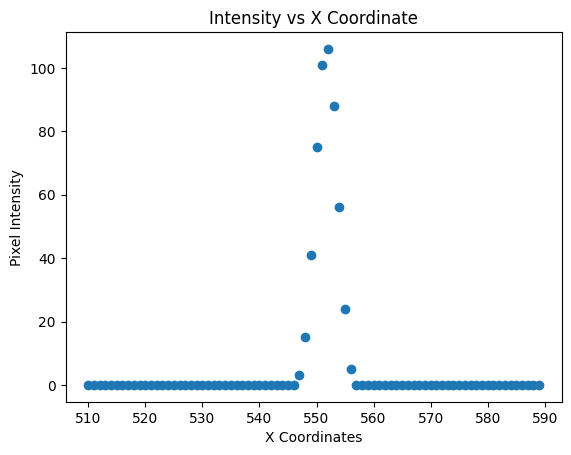

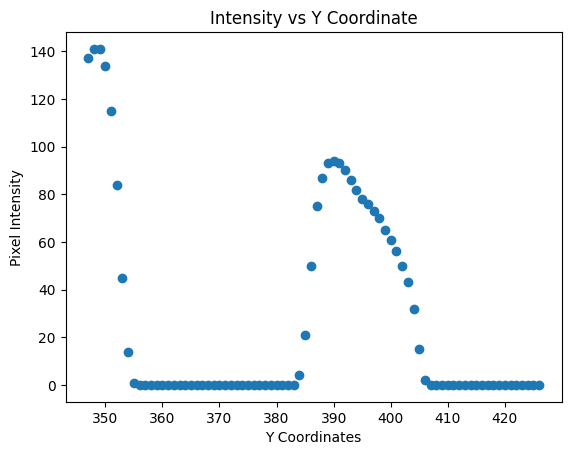

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/32_64_32_X_3600000.bmp
Pixel location with intensity > 50:
X: 550
Y: 681
Center X: 750
Center Y: 564


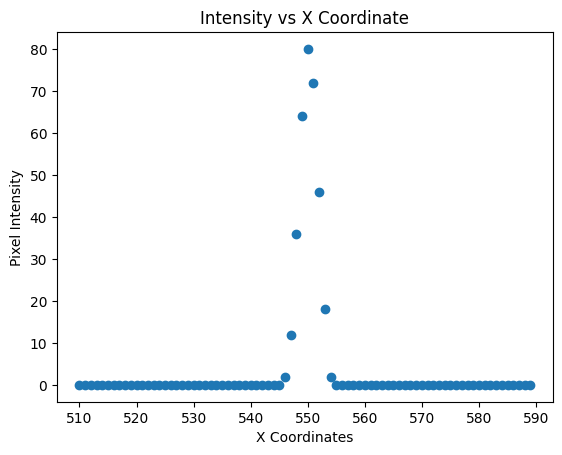

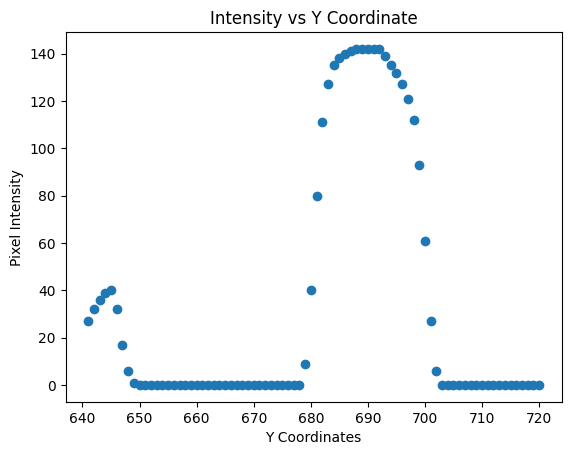

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/32_8_32_clear_3600000.bmp
Pixel location with intensity > 50:
X: 550
Y: 386
Center X: 750
Center Y: 564


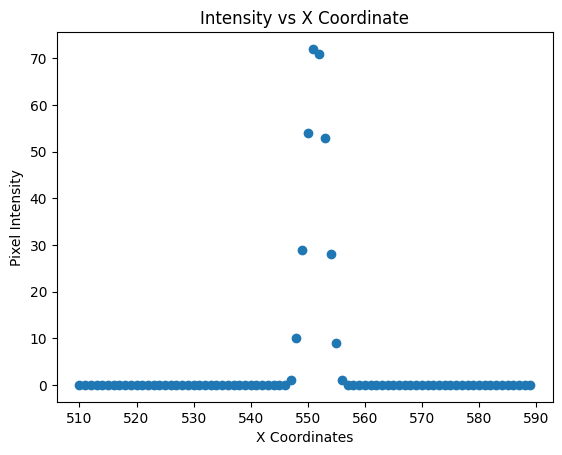

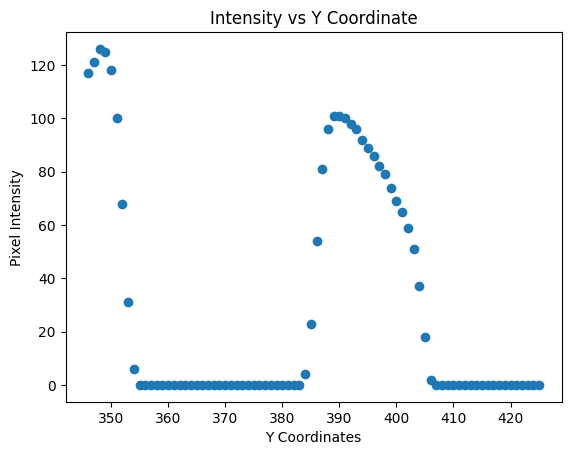

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/32_8_32_X_3600000.bmp
Pixel location with intensity > 50:
X: 550
Y: 681
Center X: 750
Center Y: 564


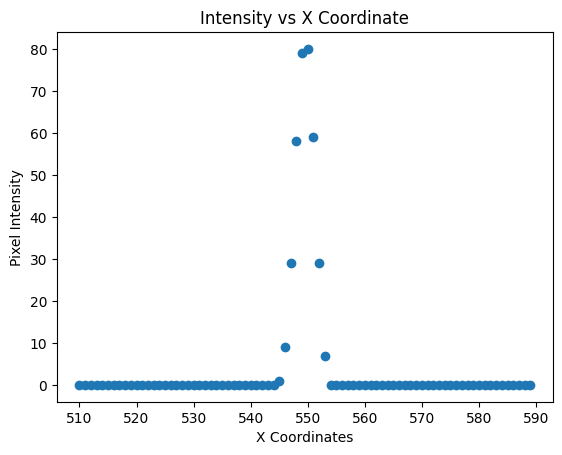

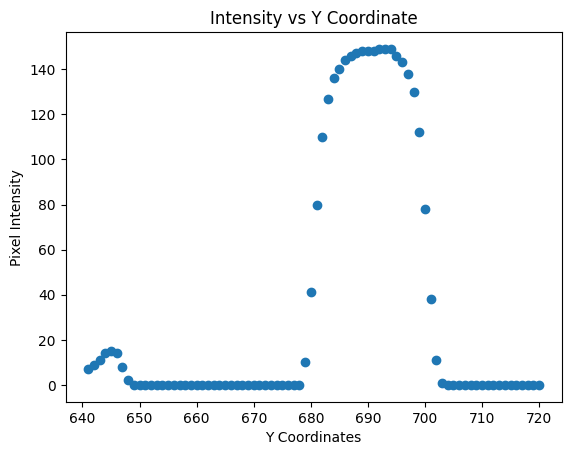

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/64_128_64_clear_750000.bmp
Pixel location with intensity > 50:
X: 550
Y: 628
Center X: 750
Center Y: 564


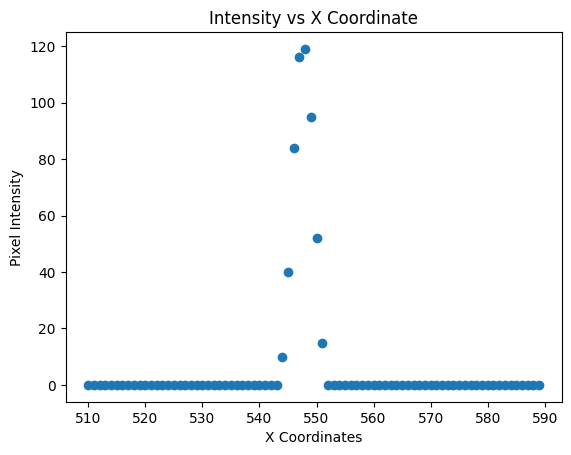

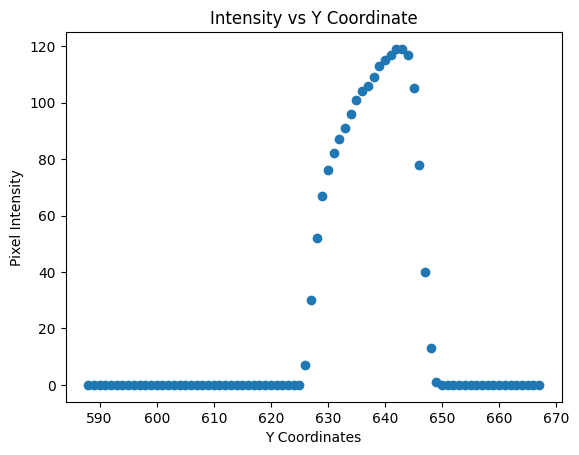

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/64_128_64_X_750000.bmp
Pixel location with intensity > 50:
X: 550
Y: 628
Center X: 750
Center Y: 564


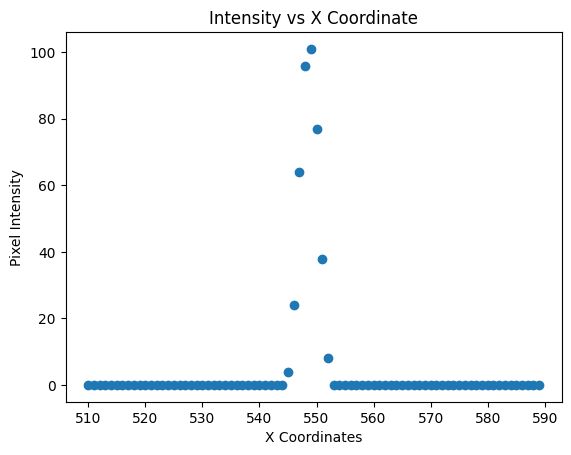

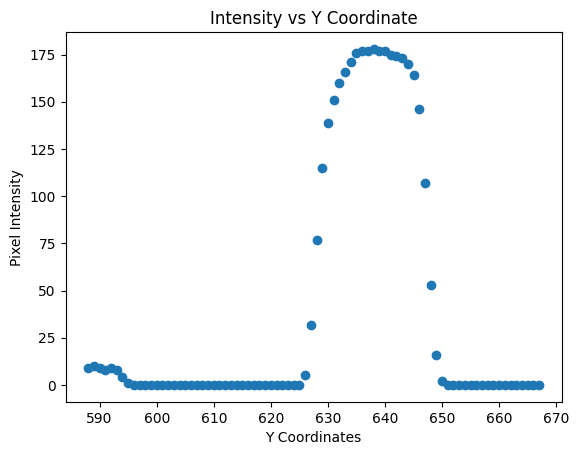

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/64_16_64_clear_750000.bmp
Pixel location with intensity > 50:
X: 550
Y: 629
Center X: 750
Center Y: 564


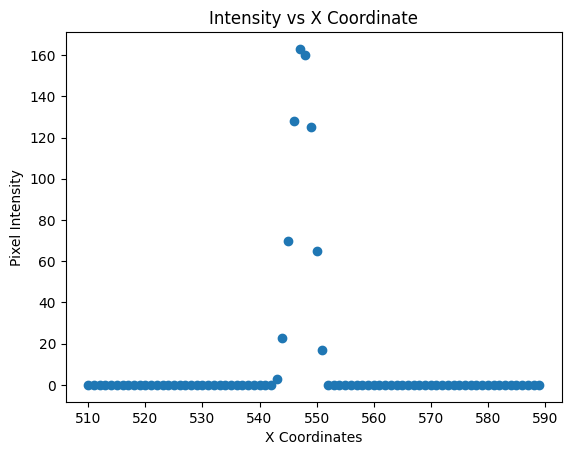

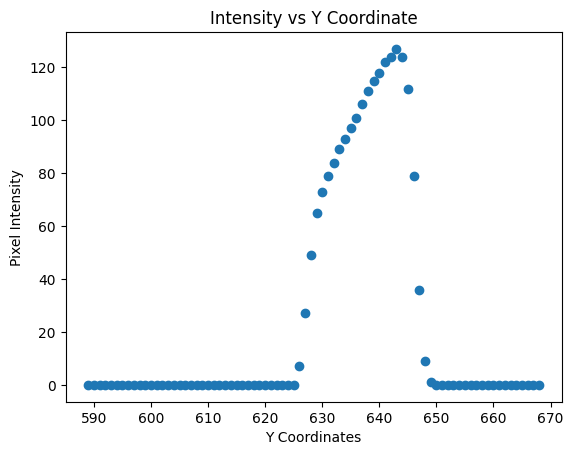

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/64_16_64_X_750000.bmp
Pixel location with intensity > 50:
X: 550
Y: 628
Center X: 750
Center Y: 564


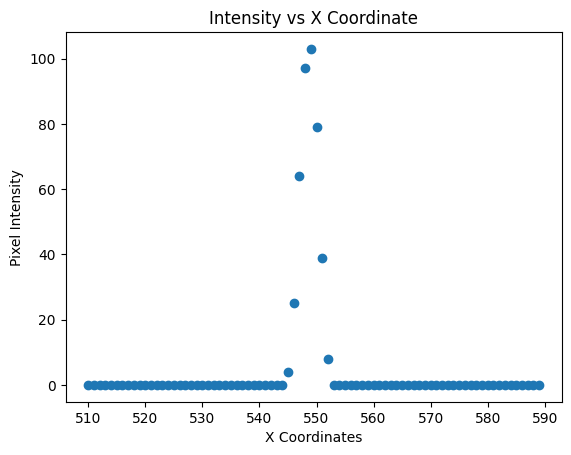

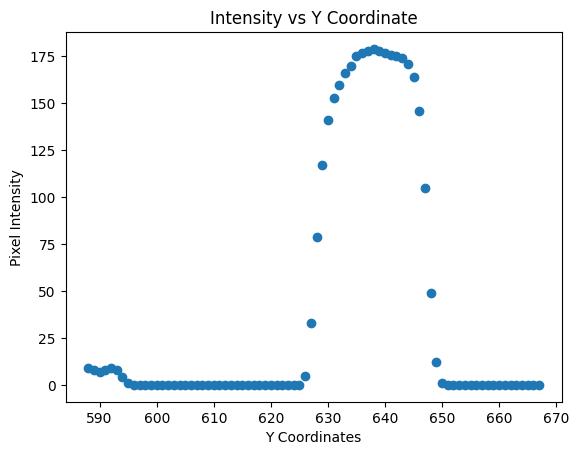

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/64_32_64_clear_750000.bmp
Pixel location with intensity > 50:
X: 550
Y: 628
Center X: 750
Center Y: 564


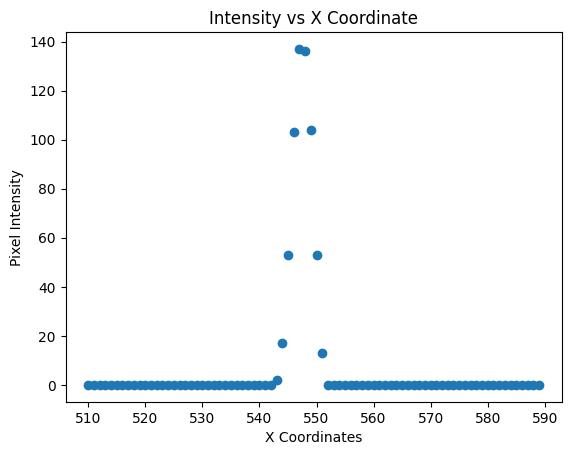

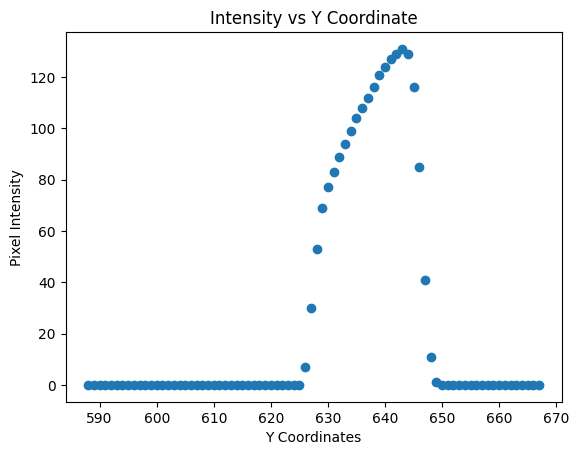

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/64_32_64_X_750000.bmp
Pixel location with intensity > 50:
X: 550
Y: 628
Center X: 750
Center Y: 564


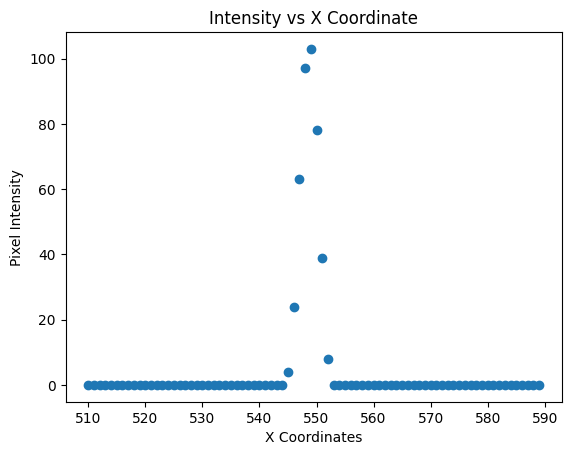

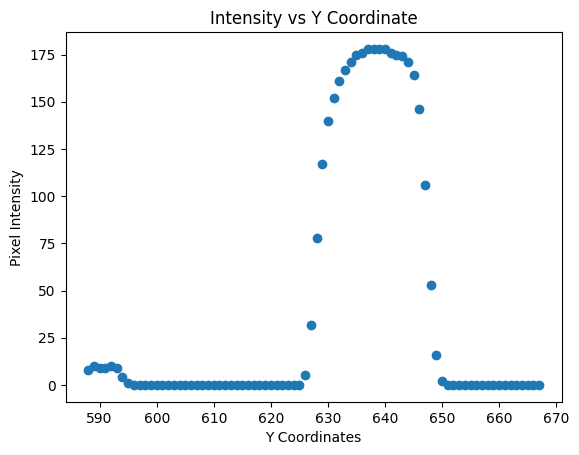

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/64_4_64_clear_750000.bmp
Pixel location with intensity > 50:
X: 550
Y: 629
Center X: 750
Center Y: 564


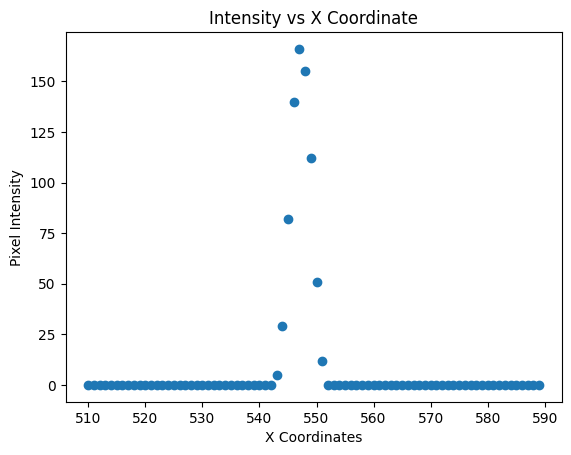

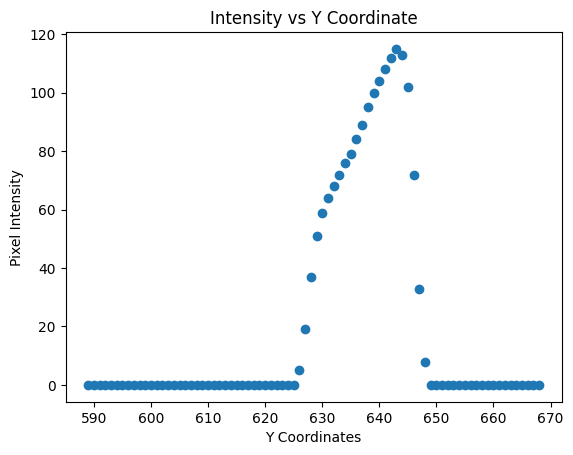

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/64_4_64_X_750000.bmp
Pixel location with intensity > 50:
X: 550
Y: 628
Center X: 750
Center Y: 564


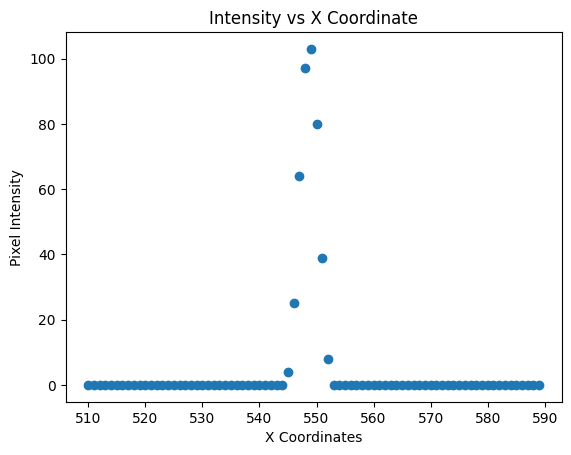

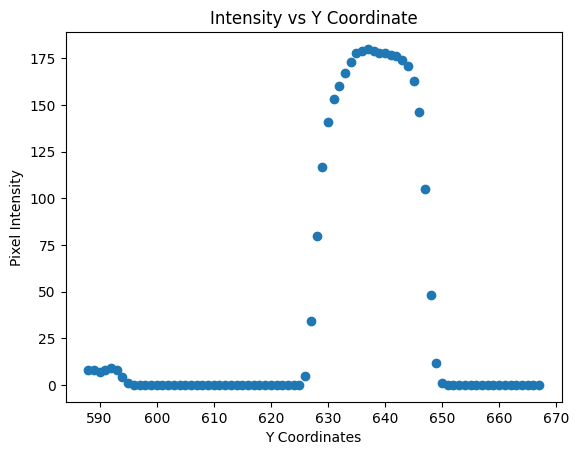

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/64_64_128_clear_750000.bmp
Pixel location with intensity > 50:
X: 550
Y: 628
Center X: 750
Center Y: 564


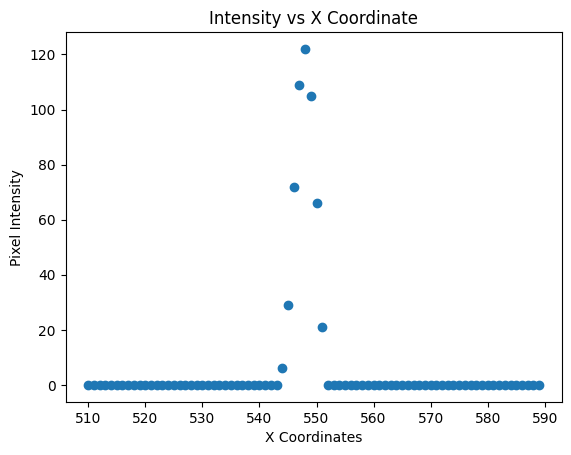

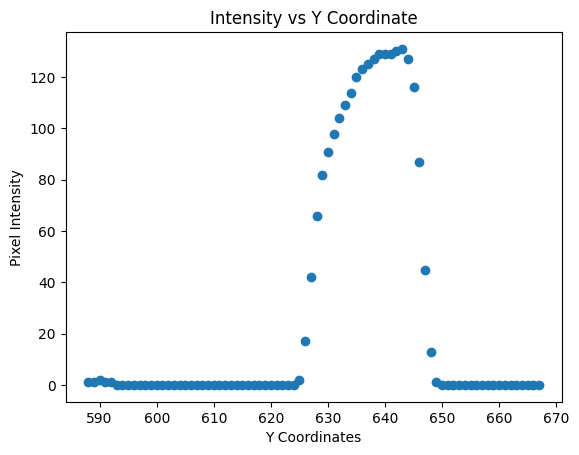

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/64_64_128_X_750000.bmp
Pixel location with intensity > 50:
X: 550
Y: 628
Center X: 750
Center Y: 564


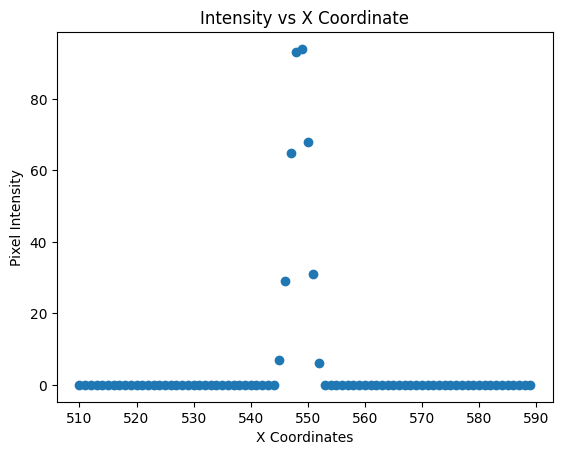

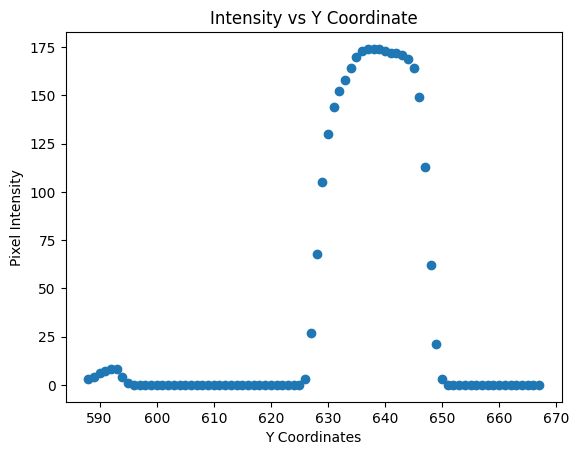

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/64_64_16_clear_750000.bmp
Pixel location with intensity > 50:
X: 550
Y: 628
Center X: 750
Center Y: 564


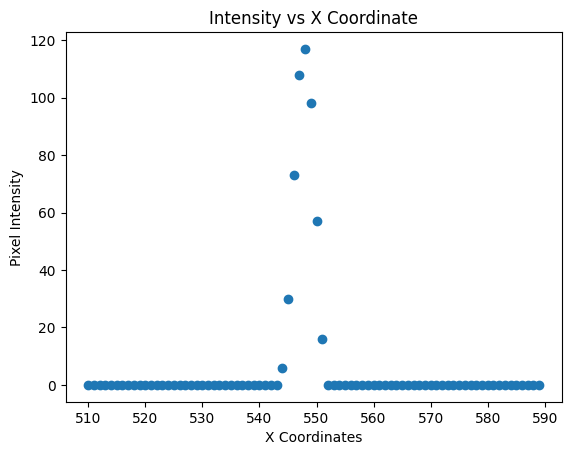

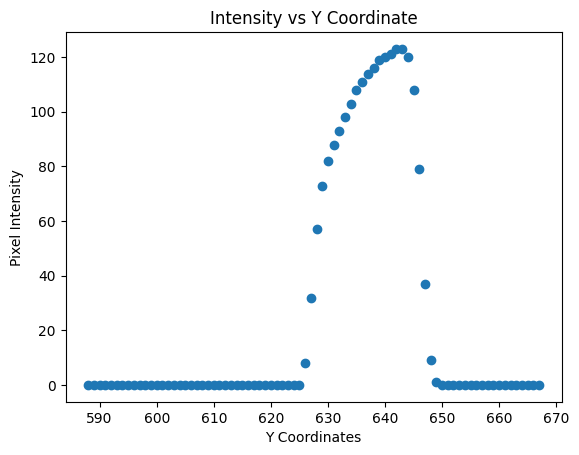

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/64_64_16_X_750000.bmp
Pixel location with intensity > 50:
X: 550
Y: 628
Center X: 750
Center Y: 564


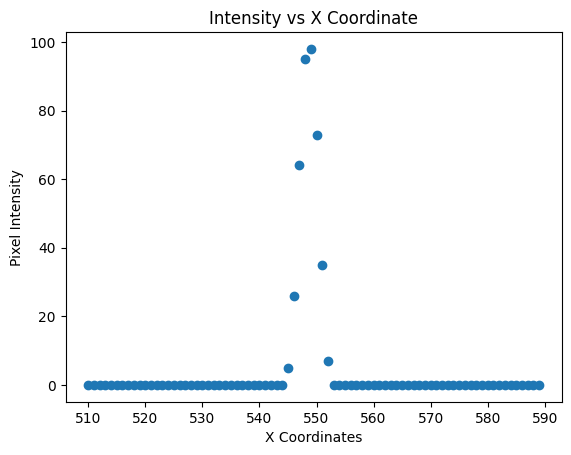

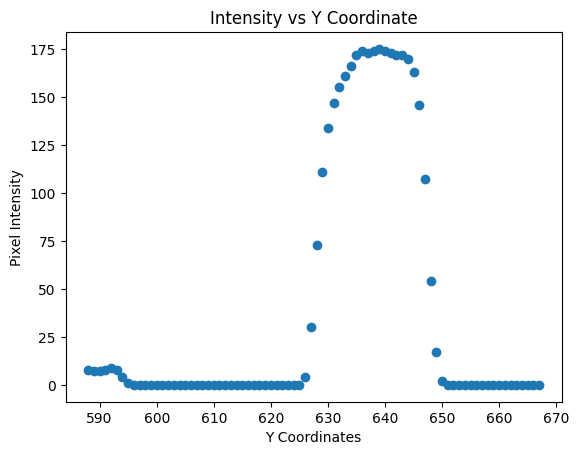

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/64_64_32_clear_750000.bmp
Pixel location with intensity > 50:
X: 550
Y: 628
Center X: 750
Center Y: 564


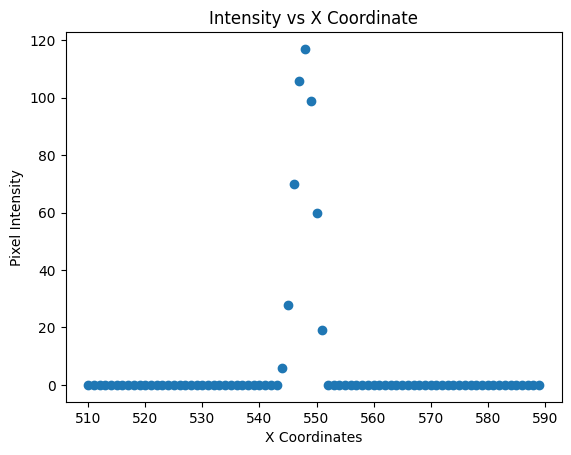

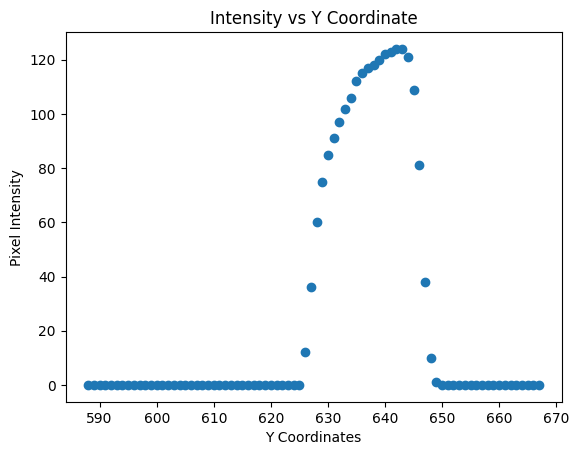

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/64_64_32_X_750000.bmp
Pixel location with intensity > 50:
X: 550
Y: 628
Center X: 750
Center Y: 564


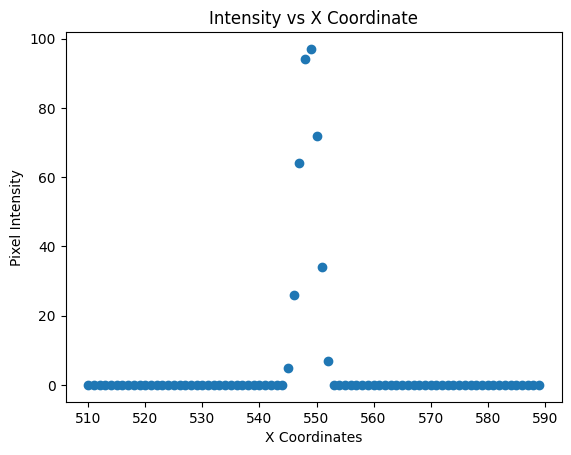

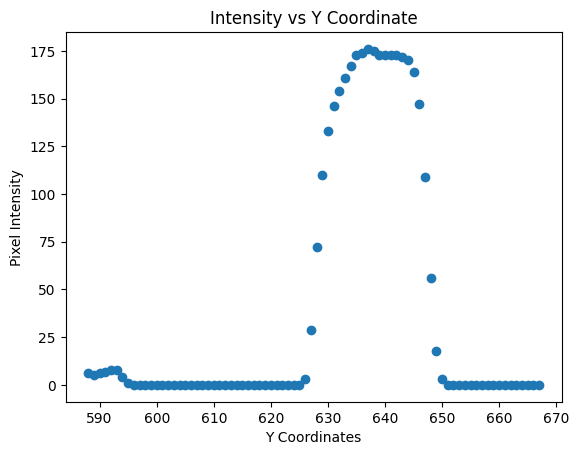

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/64_64_4_clear_750000.bmp
Pixel location with intensity > 50:
X: 550
Y: 628
Center X: 750
Center Y: 564


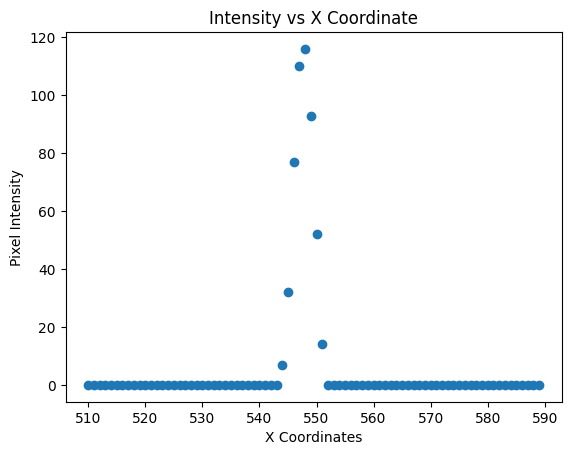

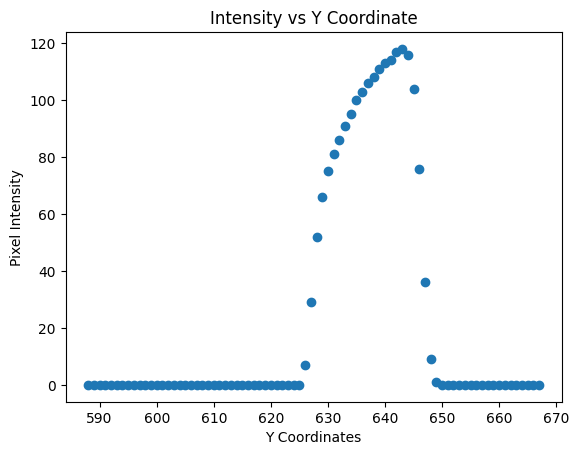

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/64_64_4_X_750000.bmp
Pixel location with intensity > 50:
X: 550
Y: 628
Center X: 750
Center Y: 564


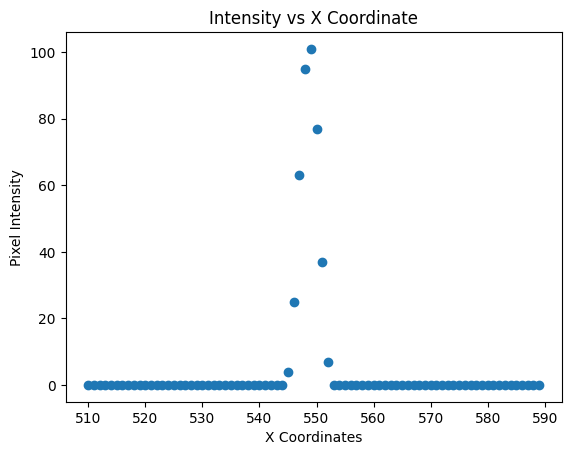

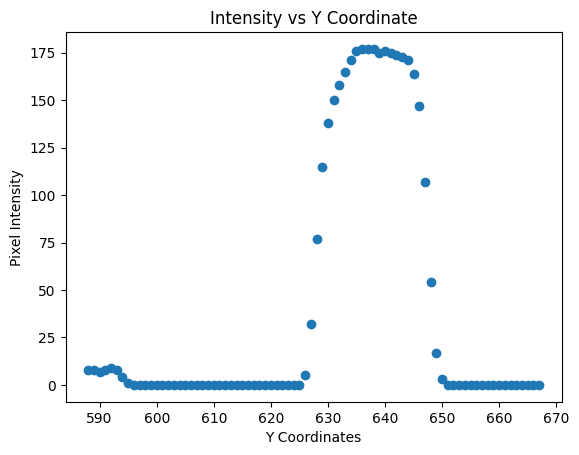

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/64_64_64_clear_750000.bmp
Pixel location with intensity > 50:
X: 550
Y: 628
Center X: 750
Center Y: 564


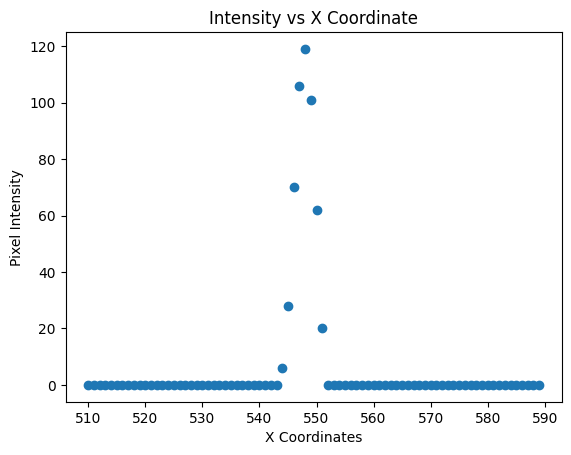

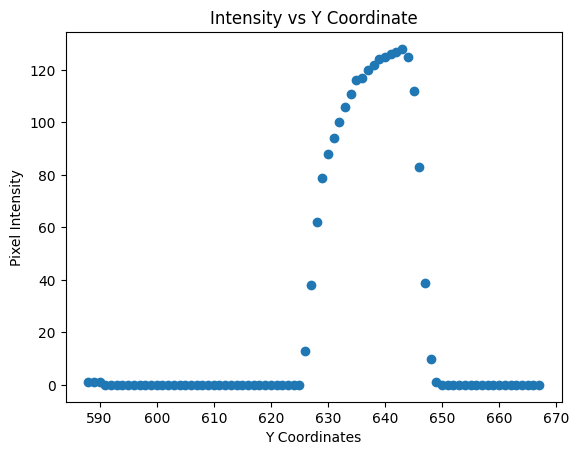

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/64_64_64_X_750000.bmp
Pixel location with intensity > 50:
X: 550
Y: 628
Center X: 750
Center Y: 564


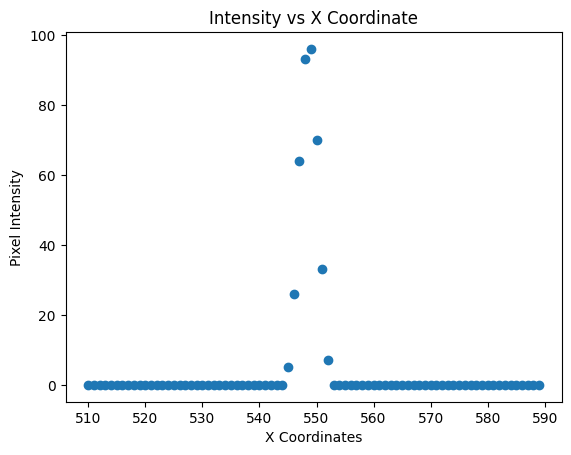

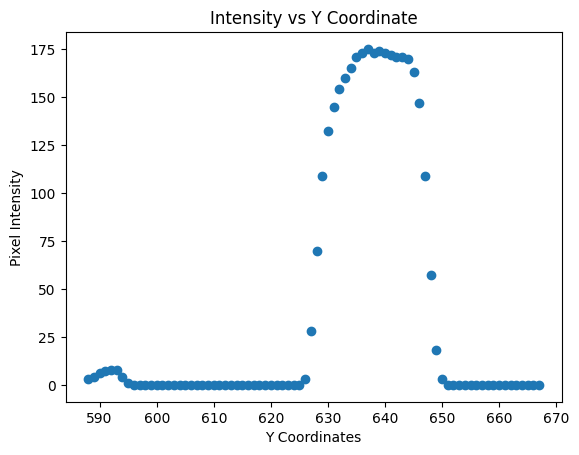

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/64_64_8_clear_750000.bmp
Pixel location with intensity > 50:
X: 550
Y: 628
Center X: 750
Center Y: 564


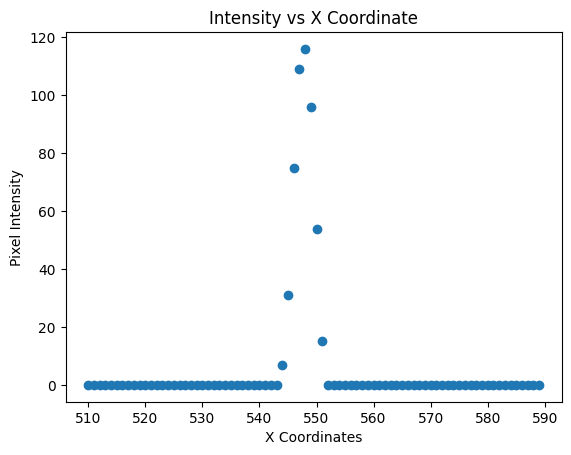

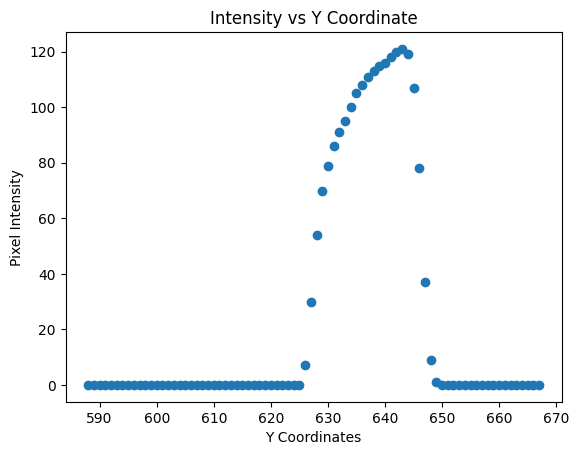

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/64_64_8_X_750000.bmp
Pixel location with intensity > 50:
X: 550
Y: 628
Center X: 750
Center Y: 564


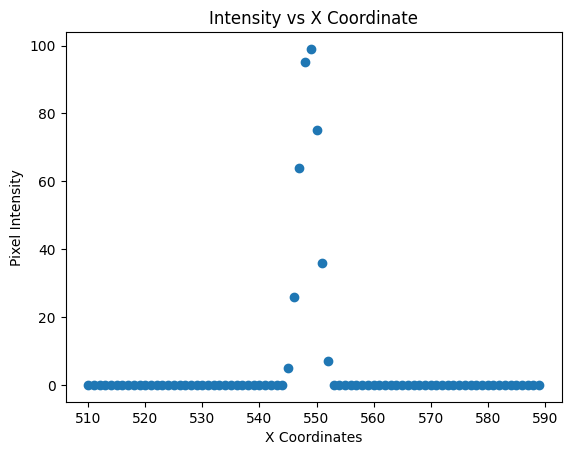

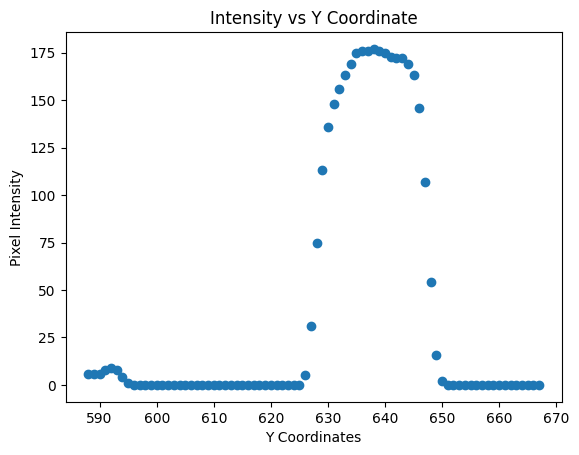

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/64_8_64_clear_750000.bmp
Pixel location with intensity > 50:
X: 550
Y: 629
Center X: 750
Center Y: 564


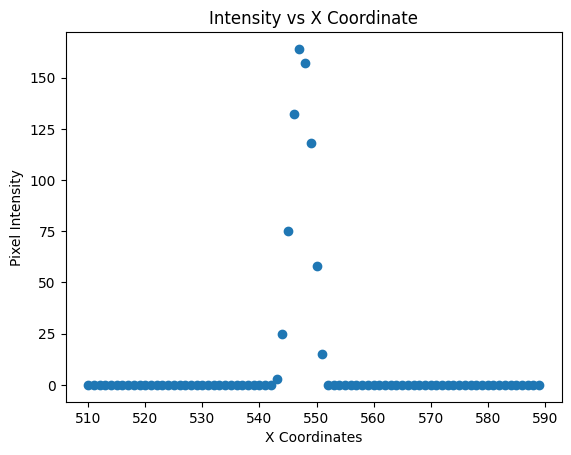

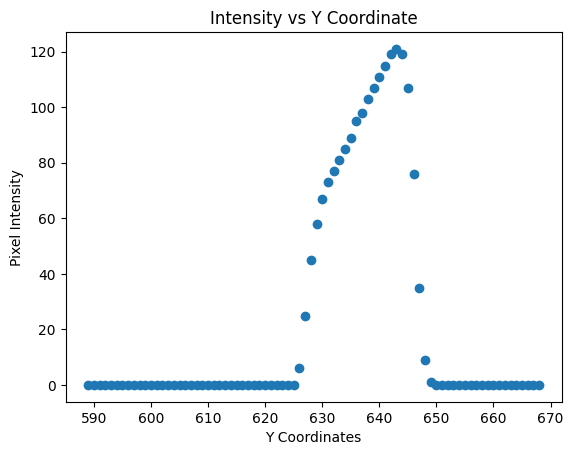

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/64_8_64_X_750000.bmp
Pixel location with intensity > 50:
X: 550
Y: 628
Center X: 750
Center Y: 564


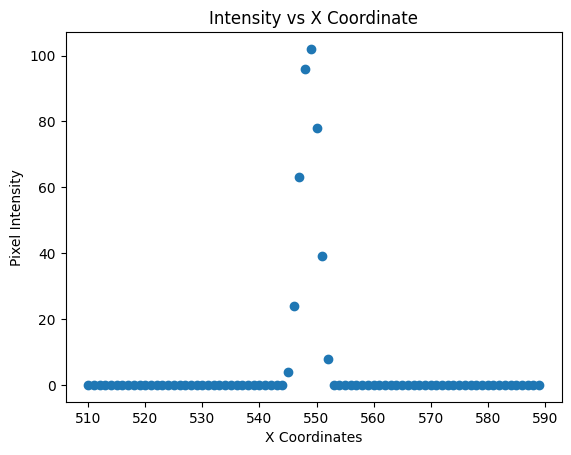

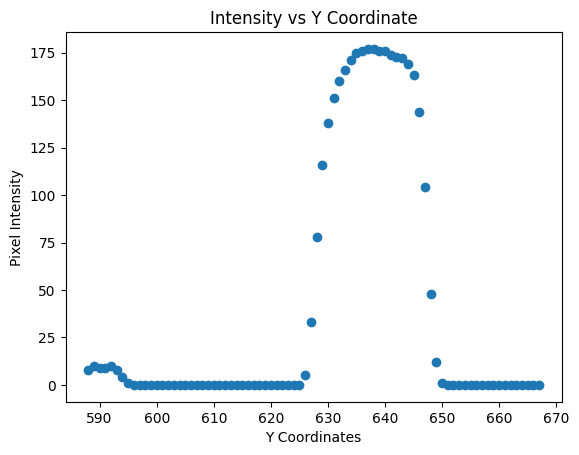

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/8_16_8_clear_60000000.bmp
Pixel location with intensity > 50:
X: 550
Y: 685
Center X: 750
Center Y: 564


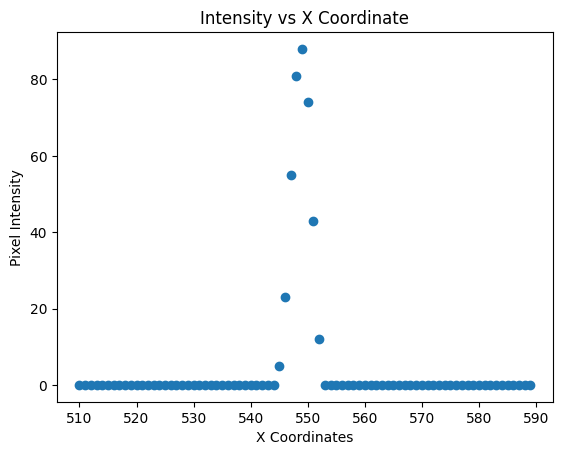

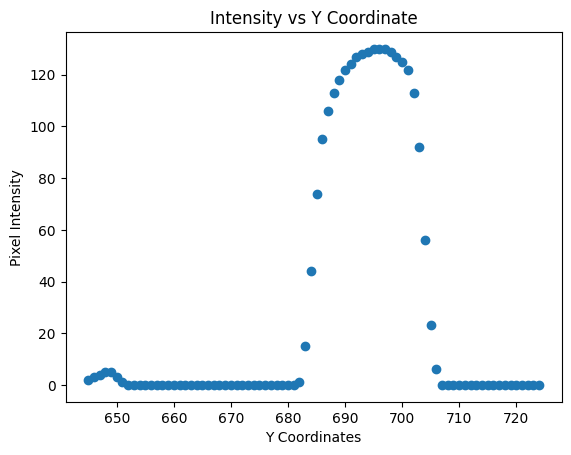

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/8_16_8_X_60000000.bmp
Pixel location with intensity > 50:
X: 550
Y: 690
Center X: 750
Center Y: 564


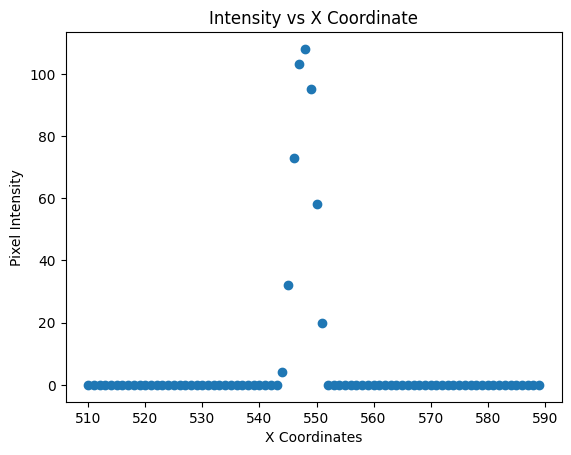

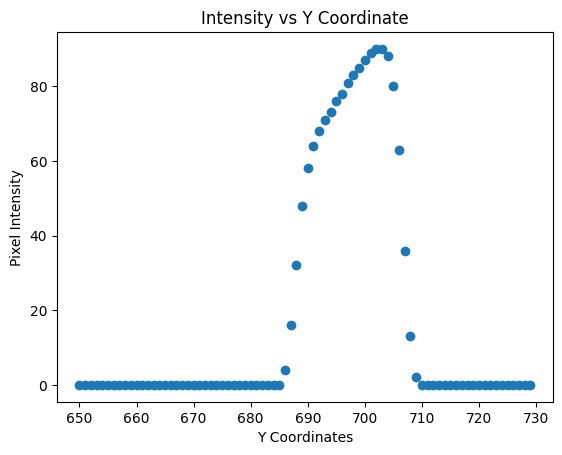

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/8_32_8_clear_60000000.bmp
Pixel location with intensity > 50:
X: 550
Y: 685
Center X: 750
Center Y: 564


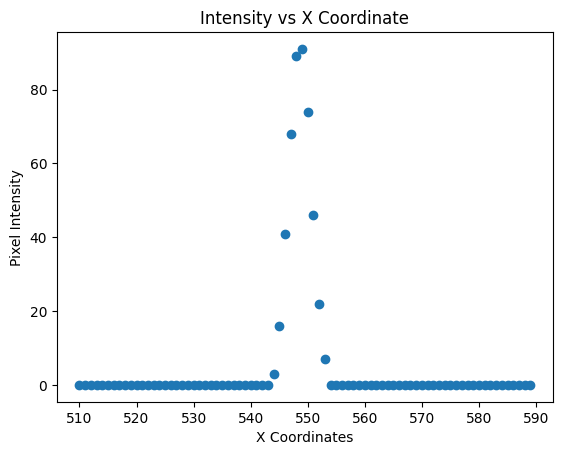

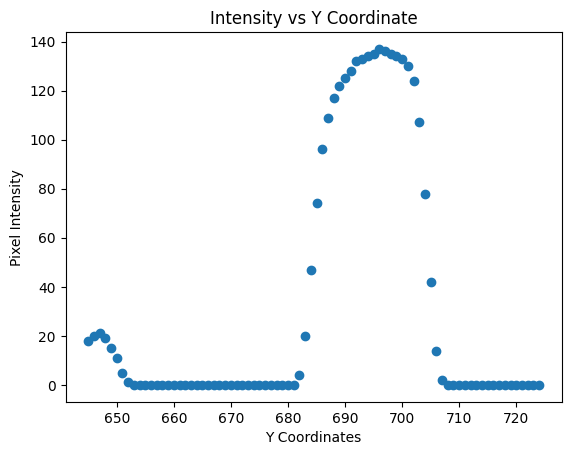

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/8_32_8_X_60000000.bmp
Pixel location with intensity > 50:
X: 550
Y: 690
Center X: 750
Center Y: 564


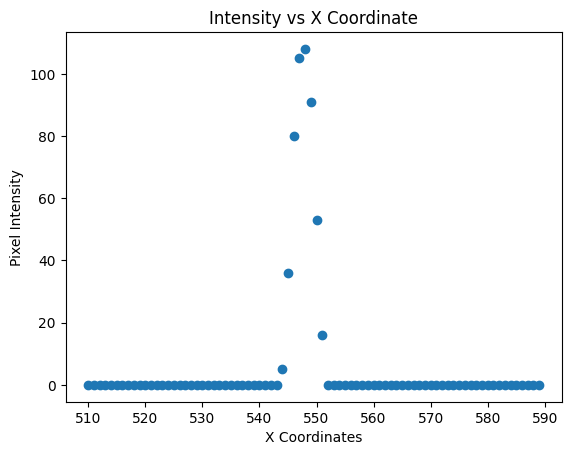

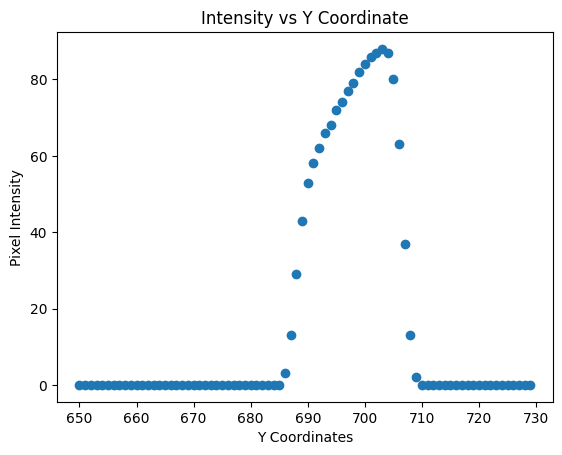

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/8_4_8_clear_60000000.bmp
Pixel location with intensity > 50:
X: 550
Y: 684
Center X: 750
Center Y: 564


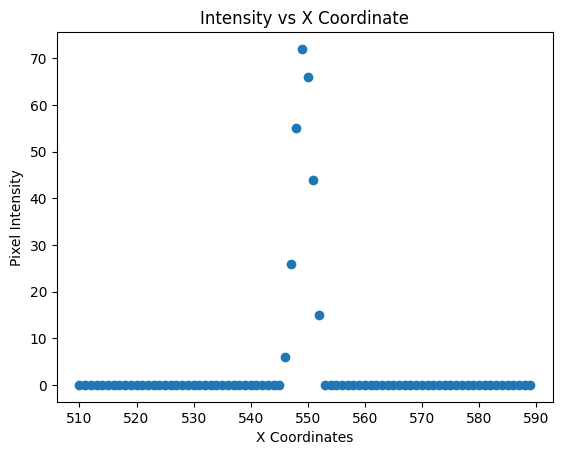

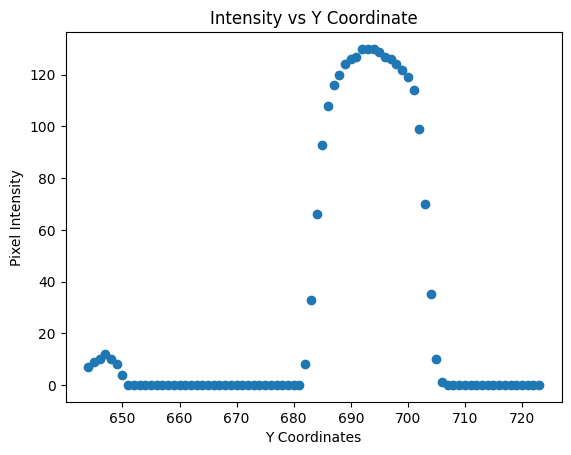

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/8_4_8_X_60000000.bmp
Pixel location with intensity > 50:
X: 550
Y: 689
Center X: 750
Center Y: 564


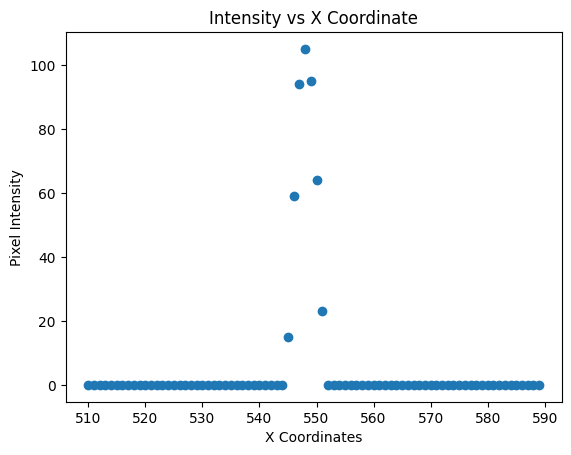

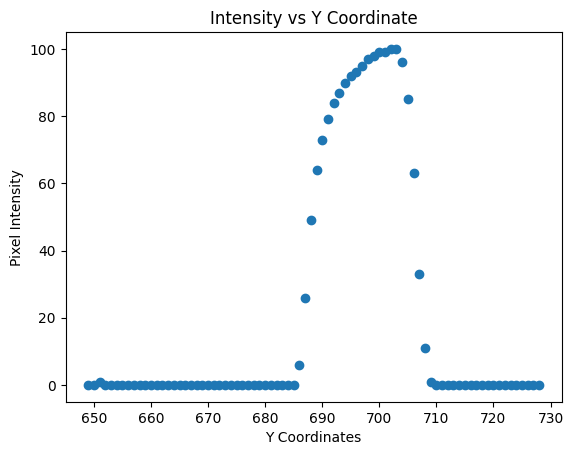

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/8_64_8_clear_60000000.bmp
Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/8_64_8_X_60000000.bmp
Pixel location with intensity > 50:
X: 550
Y: 690
Center X: 750
Center Y: 564


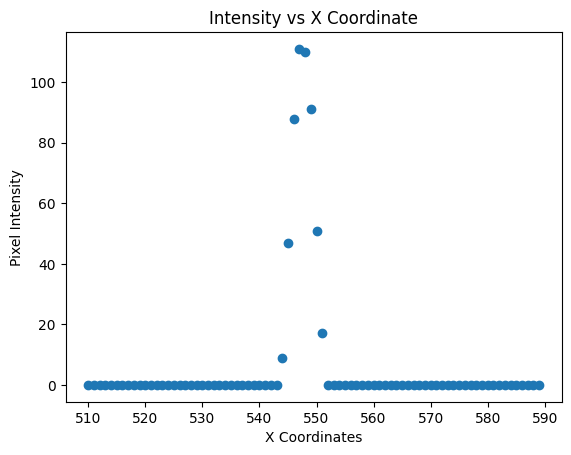

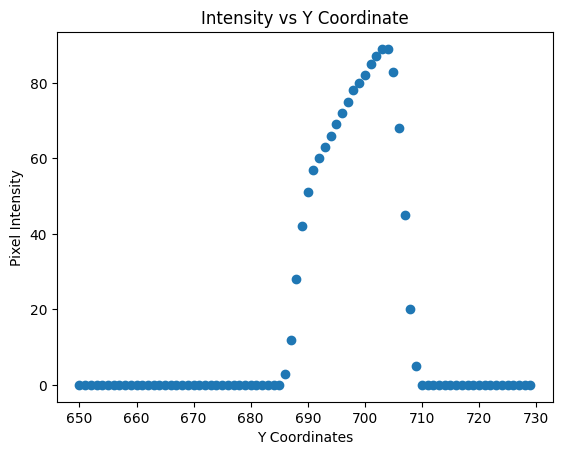

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/8_8_128_X_60000000.bmp
Pixel location with intensity > 50:
X: 550
Y: 394
Center X: 750
Center Y: 564


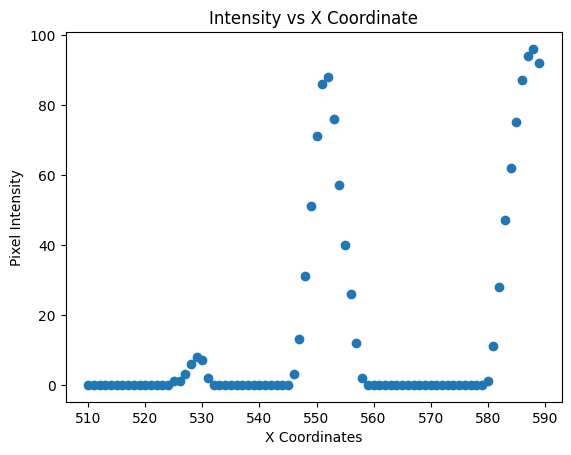

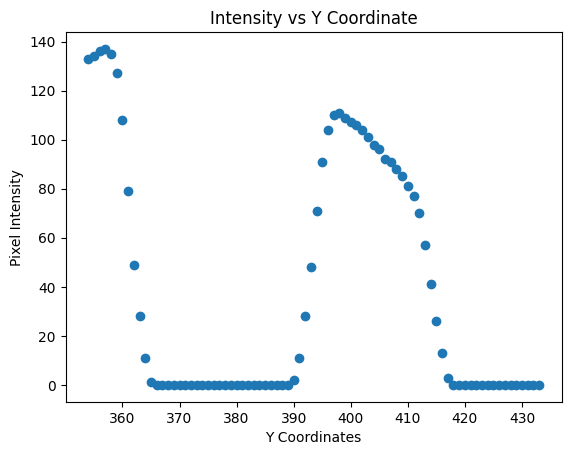

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/8_8_16_clear_60000000.bmp
Pixel location with intensity > 50:
X: 550
Y: 687
Center X: 750
Center Y: 564


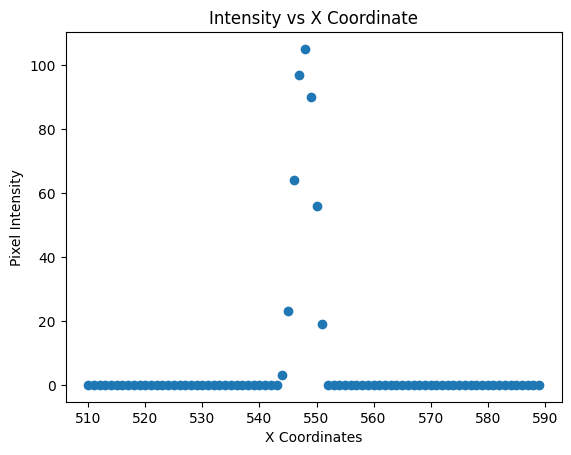

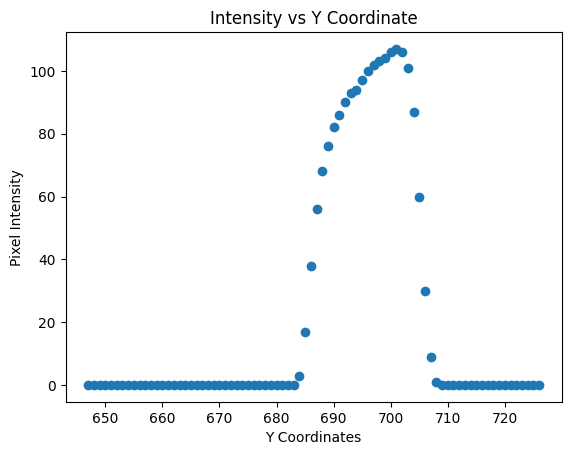

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/8_8_16_X_60000000.bmp
Pixel location with intensity > 50:
X: 550
Y: 397
Center X: 750
Center Y: 564


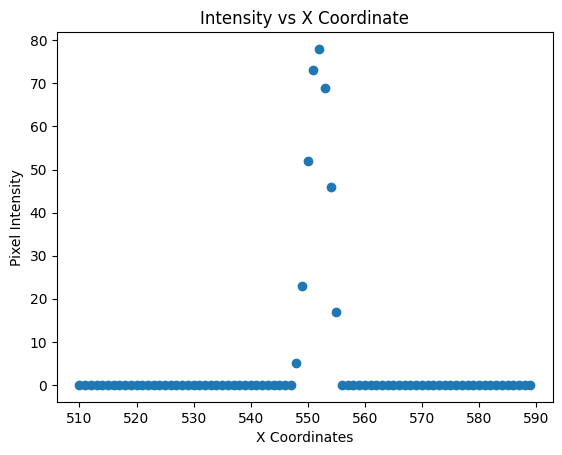

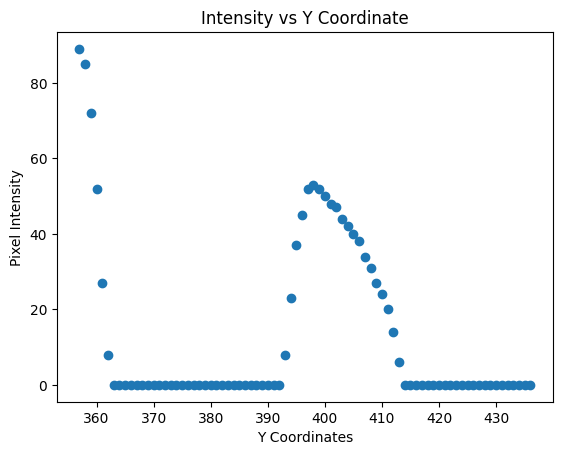

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/8_8_32_clear_60000000.bmp
Pixel location with intensity > 50:
X: 709
Y: 728
Center X: 750
Center Y: 564


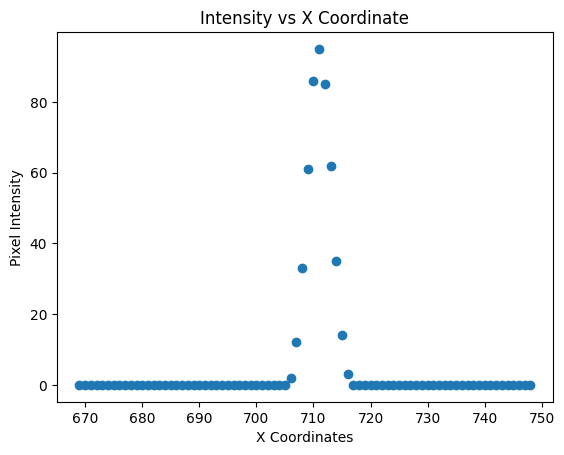

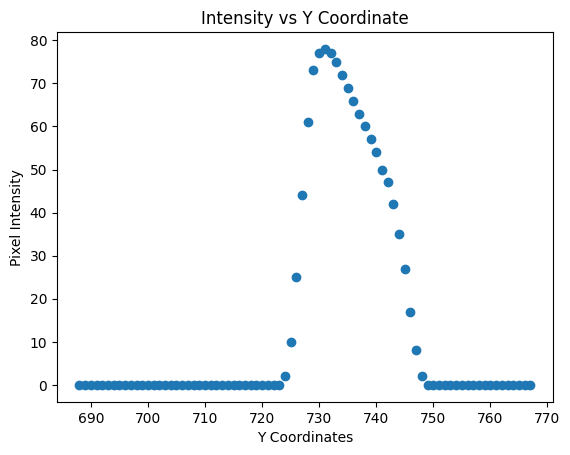

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/8_8_32_X_60000000.bmp
Pixel location with intensity > 50:
X: 550
Y: 396
Center X: 750
Center Y: 564


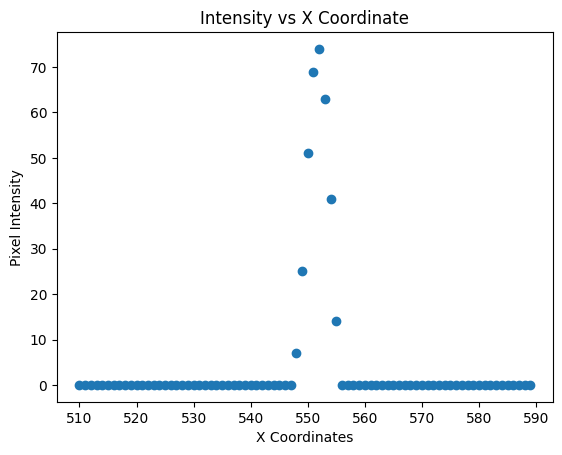

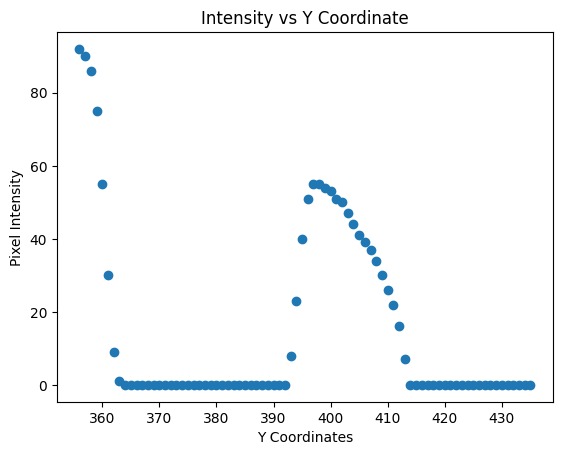

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/8_8_4_clear_60000000.bmp
Pixel location with intensity > 50:
X: 550
Y: 686
Center X: 750
Center Y: 564


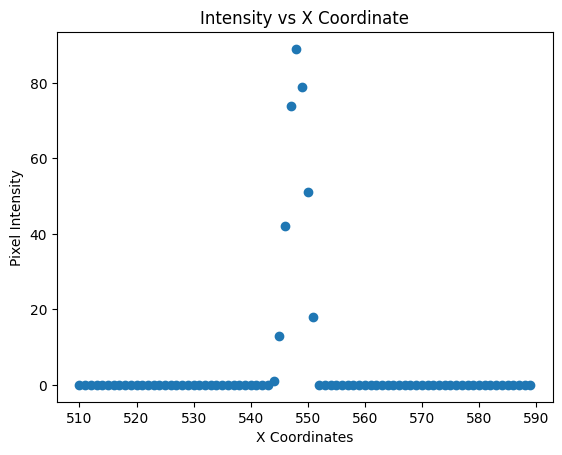

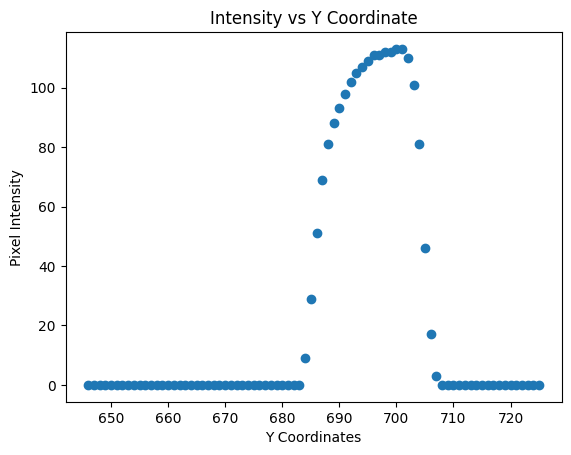

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/8_8_4_X_60000000.bmp
Pixel location with intensity > 50:
X: 550
Y: 694
Center X: 750
Center Y: 564


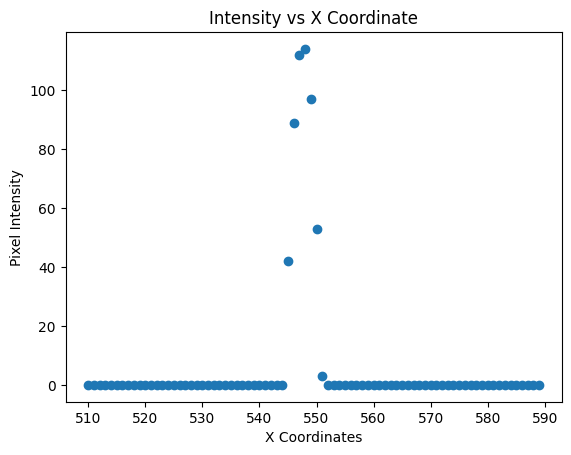

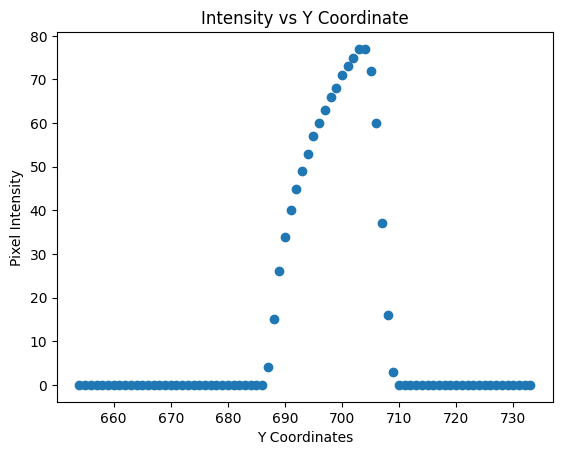

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/8_8_64_clear_60000000.bmp
Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/8_8_64_X_60000000.bmp
Pixel location with intensity > 50:
X: 550
Y: 396
Center X: 750
Center Y: 564


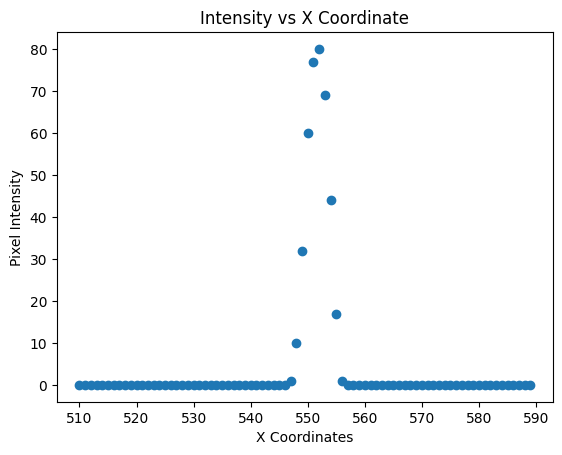

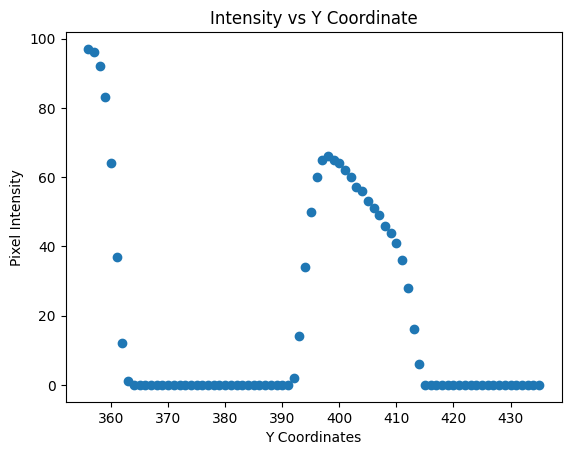

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/8_8_8_clear_60000000.bmp
Pixel location with intensity > 50:
X: 550
Y: 690
Center X: 750
Center Y: 564


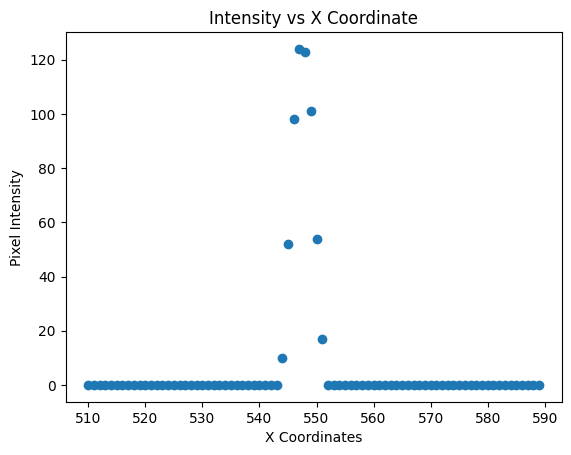

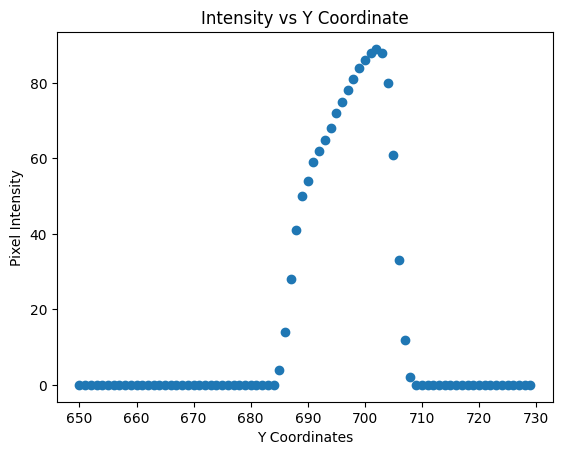

Rotating image file: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/thresholded/red/8_8_8_X_60000000.bmp
Pixel location with intensity > 50:
X: 550
Y: 689
Center X: 750
Center Y: 564


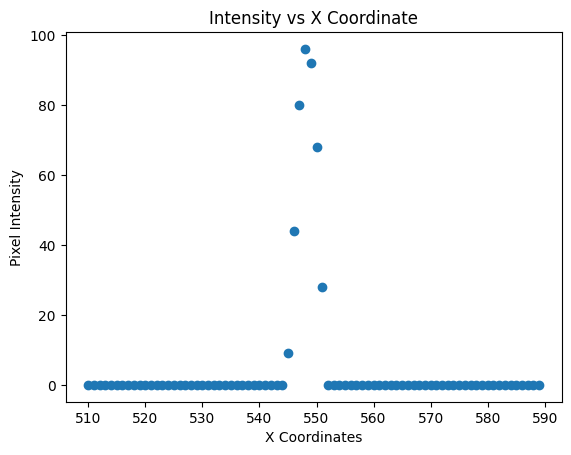

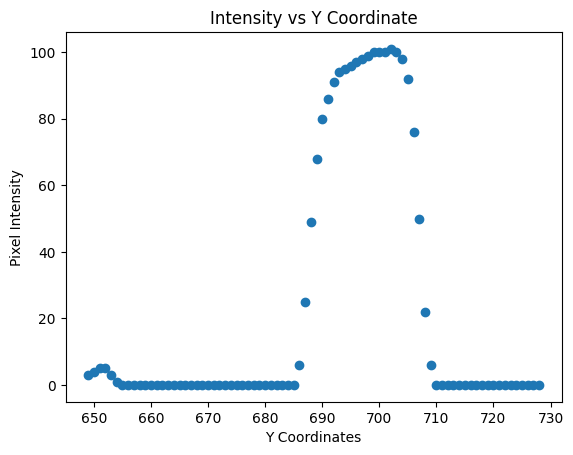

In [10]:
directory = "/mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data/"

image_files = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith((".jpg", ".jpeg", ".png", ".bmp"))]

# #1 preprocess images to filter out RGB
# threshold_val = 0
# for image_file in image_files:
#     if threshold_val == 0:
#         threshold_val = preprocess_image(image_file)
#     else:
#         preprocess_image(image_file, threshold_val = threshold_val)


#2 straighten image by rotating 1 degree clockwise
directory = directory + "thresholded/"
for color in ["red"]: #we are only filtering out red for now
    color_directory = directory+color+"/"
    
    image_files = [os.path.join(color_directory, file) for file in os.listdir(color_directory) if file.endswith((".jpg", ".jpeg", ".png", ".bmp"))]
    for image_file in image_files:
        
        print("Rotating image file:", image_file)
        image_path = image_file
        rotated_image = rotate_image(image_path, 359)
        rotated_image.save(image_path)
        rotated_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

#3 construct scatter plot of pixel intensities 
        # Get the dimensions of the image
        height, width = rotated_image.shape[:2]

        # Find the middle coordinates
        middle_x = width // 2
        middle_y = height // 2
        x=0
        y=0
        # Define the neighborhood size
        neighborhood_size = 200  # Adjust the size as needed


        # Search for a pixel with intensity > 50 in the neighborhood
        found_pixel = False
        for i in range(-neighborhood_size, neighborhood_size + 1):
            for j in range(-neighborhood_size, neighborhood_size + 1):
                x = middle_x + i
                y = middle_y + j

                # Get the pixel value at the current coordinates
                pixel_value = rotated_image[x,y]
                # Check if the pixel intensity is greater than 50
                if pixel_value > 50:
                    found_pixel = True
                    break

            if found_pixel:
                break

        # Check if a suitable pixel was found
        if found_pixel:
            print("Pixel location with intensity > 50:")
            print("X:", x)
            print("Y:", y)
            # Print the center coordinates
            print("Center X:", middle_x)
            print("Center Y:", middle_y)

            plot_intensity_vs_x(image_path, x,y)
            plot_intensity_vs_y(image_path,x,y)
            

In [ ]:
# try different threshold, and save these images
import cv2 
import numpy as np
import csv

# Read image in grayscale
image_path = "/mnt/c/Users/alada/JC_Code/JC-SDKIntegration/Red32/32_32_32_clear_4000.bmp"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
image = extract_middle_roi(image, 1500)

# Initialize a list to store the results
results = []

for threshold in range(5, 50):
    _, filtered_image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)
    new_path = "/mnt/c/Users/alada/JC_Code/JC-SDKIntegration/ThresholdExperiment/threshold=" + str(threshold) + ".bmp"
#     cv2.imwrite(new_path, filtered_image)
    
    # for each image, find the average, sd, and average + sd, and export them to a csv file
    
    # Perform calculations for black pixels
    black_mask = np.where(image < threshold, 1, 0)
    black_masked_intensities = image[black_mask == 1]
    black_mean_intensity = np.mean(black_masked_intensities)
    black_sd_intensity = np.std(black_masked_intensities)
    black_one_sd = black_mean_intensity + (1 * black_sd_intensity)
    black_two_sd = black_mean_intensity + (2 * black_sd_intensity)
    
    # Perform calculations for white pixels
    white_mask = np.where(image >= threshold, 1, 0)
    white_masked_intensities = image[white_mask == 1]
    white_mean_intensity = np.mean(white_masked_intensities)
    white_sd_intensity = np.std(white_masked_intensities)
    white_one_sd = white_mean_intensity + (1 * white_sd_intensity)
    white_two_sd = white_mean_intensity + (2 * white_sd_intensity)
    
    # Store the results in a dictionary
    result = {
        'Threshold': threshold,
        'Mean Intensity of Black Pixels': black_mean_intensity,
        'Standard Deviation of Black Pixels': black_sd_intensity,
        'Black One SD Above Average': black_one_sd,
        'Black Two SD Above Average': black_two_sd,
        'Mean Intensity of White Pixels': white_mean_intensity,
        'Standard Deviation of White Pixels': white_sd_intensity,
        'White One SD Above Average': white_one_sd,
        'White Two SD Above Average': white_two_sd
    }
    results.append(result)
    
# Define the CSV file path
csv_file_path = '/mnt/c/Users/alada/JC_Code/JC-SDKIntegration/ThresholdExperiment/results.csv'

# Define the fieldnames for the CSV file
fieldnames = [
    'Threshold',
    'Mean Intensity of Black Pixels',
    'Standard Deviation of Black Pixels',
    'Black One SD Above Average',
    'Black Two SD Above Average',
    'Mean Intensity of White Pixels',
    'Standard Deviation of White Pixels',
    'White One SD Above Average',
    'White Two SD Above Average'
]

# Write the results to the CSV file
with open(csv_file_path, 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    for result in results:
        writer.writerow(result)


# Print a confirmation message
print("Results exported to results.csv")